In [3]:
# Required Libraries 
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
from itertools import islice
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash
import math
from jupyter_dash import JupyterDash
from dash import html, dash_table
import os

# Inputs 

In [4]:
# Capacity of each lane in the transportaiton network (Vehicle per hour)
ca = 600          

# BPR prameter 
alpha_1 = 4       
alpha_2 = 0.15   

# Travel time value for each mode of transportation  (Euro per hour)
travel_time_value_car = 33.98 
travel_time_value_public = 16.90
travel_time_value_bike = 20.386
travel_time_value_combined = (16.90 * 0.7) + (20.386 * 0.3)

# Fatigue parameters 
ta_1 = 0.2 
ta_2 = 0.1

# Fatigue value ()
fatigue_value = 15

#Probability of finding bikes at the station 
P = {(1) :[0.8], 
     (2) : [0.8],
     (3) : [0.8],
     (4) : [0.7],
     (5) : [0.8],
     (6) : [0.9],
     (7) : [1],
     (8) : [0.9],
     (9) : [0.6],
     (10): [1],
     (11): [0.9],
     (12): [0.8],
     (13): [0.9],
     (14): [1],
     (15): [0.9]}    # This is a value between 0 to 1 and we can change it based on the number of parking and number of bikes

# Bike speed (km per hour)
vb = 15

# Public trnasportiaton speed (km per hour)
vp = 37.82

# Emission cost (per gCo2/pkm)
# vehicle component for cars 
V_car = 25
# Fuel componet for cars 
F_car = 125
# Infrastructure component for cars 
I_Car = 15

# vehicle component for bikes 
V_bike = 25
# Fuel componet for bikes 
F_bike = 0
# Infrastructure component for bikes 
I_bike = 15

# vehicle component for public transportaiton (Metro) 
V_public = 5
# Fuel componet for public transportaiton (Metro) 
F_public = 20
# Infrastructure component for public transportaiton (Metro) 
I_public = 15

# Social cost of CO_2 (euro per ton CO2)
social_co2 = 26.07 * 10**(-6)

# Health benefit (Euro per km)
HB = 1.28   

# Running cost of bikes  (euro per veh.km)
Run_cost_bike = 0.98

# Running cost of public transportiaton (Euro per vehicle.km)
Run_cost_public = 35.49 

# Purchues cost of bikes (euro per hour)
Bike_cost = 0.091  

# Perchuse cost of public transportation (Euro per hour )
Public_cost = 29.81

In [5]:
# Initialize demand data as a list of lists
# Rows and columns represent nodes 1 to 15
data = [
    [0, 400, 200,  60,  80, 150,  75,  75,  30, 160,  30,  25,  35,   0,   0],
    [400,   0,  50, 120,  20, 180,  90,  90,  15, 130,  20,  100,  10,   5,   0],
    [200,  50,   0,  40,  60, 180,  90,  90,  15,  45,  20,  10,  10,   5,   0],
    [ 60, 120,  40,   0,  50, 100,  50,  50,  15, 240,  40,  25,  10,   5,   0],
    [ 80,  20,  60,  50,   0,  50,  25,  25,  10, 120,  20,  15,   5,   0,   0],
    [150, 180, 180, 100,  50,   0, 100, 100,  30, 880,  60,  15,  15,  10,   0],
    [ 75,  90,  90,  50,  25, 100,   0,  50,  15, 440,  35,  10,  10,   5,   0],
    [ 75,  90,  90,  50,  25, 100,  50,   0,  15, 440,  35,  10,  10,   5,   0],
    [ 30,  15,  15,  15,  10,  30,  15,  15,   0, 140,  20,   5,   0,   0,   0],
    [160, 130,  45, 240, 120, 880, 440, 440, 140,   0, 600, 250, 500, 200,   0],
    [ 30,  20,  20,  40,  20,  60,  35,  35,  20, 600,   0,  75,  95,  15,   0],
    [ 25,  100,  10,  25,  15,  15,  10,  10,   5, 250,  75,   0,  70,   0,   0],
    [ 35,  10,  10,  10,   5,  15,  10,  10,   0, 500,  95,  70,   0,  45,   0],
    [  0,   5,   5,   5,   0,  10,   5,   5,   0, 200,  15,   0,  45,   0,   0],
    [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
]  # Demand per hour (peak hour)

# Create DataFrame with nodes 1 to 15 as rows and columns
nodes = list(range(1, 16))  # Node numbers from 1 to 15
Demand = pd.DataFrame(data, index=nodes, columns=nodes)

In [6]:
FFT = [
    [0, 3.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [3, 0.0, 4.2, 6.0, 0.0, 5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0, 4.2, 0.0, 5.6, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0, 6.0, 5.6, 0.0, 7.0, 0, 8.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0, 0.0, 0.0, 7.0, 0.0, 0, 0.0, 6.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0, 5.0, 0.0, 0.0, 0.0, 0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0, 0.0, 0.0, 8.4, 0.0, 6, 0.0, 0.0, 7.4, 0.0, 0.0, 0.0, 8.2, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 6.2, 0, 0.0, 0.0, 0.0, 8.0, 10.4, 0.0, 0.0, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 7.4, 0.0, 0.0, 0.0, 7.2, 0.0, 5.8, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 8.0, 0.0, 0.0, 6.4, 5.6, 0.0, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 10.4, 7.2, 6.4, 0.0, 6.8, 0.0, 7.6, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 5.6, 6.8, 0.0, 0.0, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 8.2, 0.0, 5.8, 0.0, 0.0, 0.0, 0.0, 9.2, 9.8],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 7.6, 0.0, 9.2, 0.0, 0.0],
    [0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.8, 0.0, 0.0]
] # Per Min 

# Node indices
nodes = list(range(1, 16))

# Create the two DataFrames
FREE_FLOW_TRAVEL_TIME = pd.DataFrame(FFT, index=nodes, columns=nodes)

In [7]:
lengths = [
    [0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [1.5, 0.0, 2.1, 3.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 2.1, 0.0, 2.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 3.0, 2.8, 0.0, 3.5, 0.0, 4.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 3.5, 0.0, 0.0, 0.0, 3.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 4.2, 0.0, 3.0, 0.0, 0.0, 3.7, 0.0, 0.0, 0.0, 4.1, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 3.1, 0.0, 0.0, 0.0, 0.0, 4.0, 5.2, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7, 0.0, 0.0, 0.0, 3.6, 0.0, 2.9, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 3.2, 2.8, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2, 3.2, 3.2, 0.0, 3.4, 0.0, 3.8, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8, 3.4, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1, 0.0, 2.9, 0.0, 0.0, 0.0, 0.0, 4.6, 4.9],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8, 0.0, 4.6, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.9, 0.0, 0.0]
] # Per KM 

# Create DataFrames with nodes 1 to 15 as rows and columns
nodes = list(range(1, 16))  # Node numbers from 1 to 15
THE_LENGTH = pd.DataFrame(lengths, index=nodes, columns=nodes)

# Network 

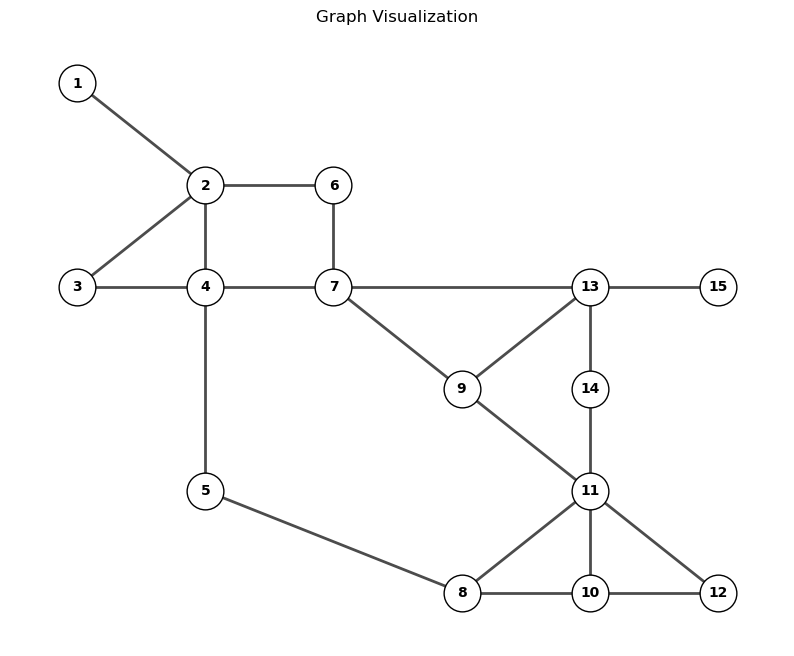

In [8]:
# Create the graph
G_ver01 = nx.Graph()

# Add edges (without displaying weights)
edges = [
    (1, 2), (2, 1), (2, 3), (2, 6), (2, 4), (3, 4), (3, 2), (4, 2), (4, 3), 
    (4, 7), (5, 8), (5, 4), (6, 2), (6, 7), (7, 6), (7,13), (7,4), (7,9), 
    (8, 5), (8, 11), (8, 10), (9, 7), (9, 11), (9,13), (10, 8), (10, 12), 
    (10, 11), (11, 10), (11, 12), (11,8), (11, 9), (11,14), (12, 10), (12, 11), (13, 7), 
    (13, 9), (13, 14), (13,15), (14, 11), (14, 13), (15, 13)
]

# Add nodes and edges to the graph
G_ver01.add_edges_from(edges)

# Manually define positions to resemble the image
pos = {
    1: (0, 5), 2: (1, 4), 3: (0, 3), 4: (1, 3), 5: (1, 1), 6: (2, 4),  
    7: (2, 3), 8: (3, 0), 9: (3, 2), 10: (4, 0), 11: (4, 1), 
    12: (5, 0), 13: (4, 3), 14: (4, 2), 15: (5, 3)
}

# Draw the graph
plt.figure(figsize=(10, 8))

# Draw edges and nodes without weights
nx.draw_networkx_edges(G_ver01, pos, width=2, alpha=0.7)
nx.draw_networkx_nodes(G_ver01, pos, node_size=700, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G_ver01, pos, font_size=10, font_weight='bold')

# Add title
plt.title("Graph Visualization")
plt.axis("off")
plt.show()

In [9]:
# Generate all the path between each nodes 
all_paths = {}

for i in G_ver01.nodes():
    for j in G_ver01.nodes():
        if i != j:  # Avoid self-loops
            # Generate all simple paths between node i and node j
            all_paths_possible = list(nx.all_simple_paths(G_ver01, source=i, target=j))
            
            # Store the paths in the dictionary
            all_paths[(i, j)] = all_paths_possible
all_paths[(1,12)]

[[1, 2, 3, 4, 7, 13, 9, 11, 8, 10, 12],
 [1, 2, 3, 4, 7, 13, 9, 11, 10, 12],
 [1, 2, 3, 4, 7, 13, 9, 11, 12],
 [1, 2, 3, 4, 7, 13, 14, 11, 8, 10, 12],
 [1, 2, 3, 4, 7, 13, 14, 11, 10, 12],
 [1, 2, 3, 4, 7, 13, 14, 11, 12],
 [1, 2, 3, 4, 7, 9, 11, 8, 10, 12],
 [1, 2, 3, 4, 7, 9, 11, 10, 12],
 [1, 2, 3, 4, 7, 9, 11, 12],
 [1, 2, 3, 4, 7, 9, 13, 14, 11, 8, 10, 12],
 [1, 2, 3, 4, 7, 9, 13, 14, 11, 10, 12],
 [1, 2, 3, 4, 7, 9, 13, 14, 11, 12],
 [1, 2, 3, 4, 5, 8, 11, 10, 12],
 [1, 2, 3, 4, 5, 8, 11, 12],
 [1, 2, 3, 4, 5, 8, 10, 12],
 [1, 2, 3, 4, 5, 8, 10, 11, 12],
 [1, 2, 6, 7, 4, 5, 8, 11, 10, 12],
 [1, 2, 6, 7, 4, 5, 8, 11, 12],
 [1, 2, 6, 7, 4, 5, 8, 10, 12],
 [1, 2, 6, 7, 4, 5, 8, 10, 11, 12],
 [1, 2, 6, 7, 13, 9, 11, 8, 10, 12],
 [1, 2, 6, 7, 13, 9, 11, 10, 12],
 [1, 2, 6, 7, 13, 9, 11, 12],
 [1, 2, 6, 7, 13, 14, 11, 8, 10, 12],
 [1, 2, 6, 7, 13, 14, 11, 10, 12],
 [1, 2, 6, 7, 13, 14, 11, 12],
 [1, 2, 6, 7, 9, 11, 8, 10, 12],
 [1, 2, 6, 7, 9, 11, 10, 12],
 [1, 2, 6, 7, 9, 11, 12],
 [1

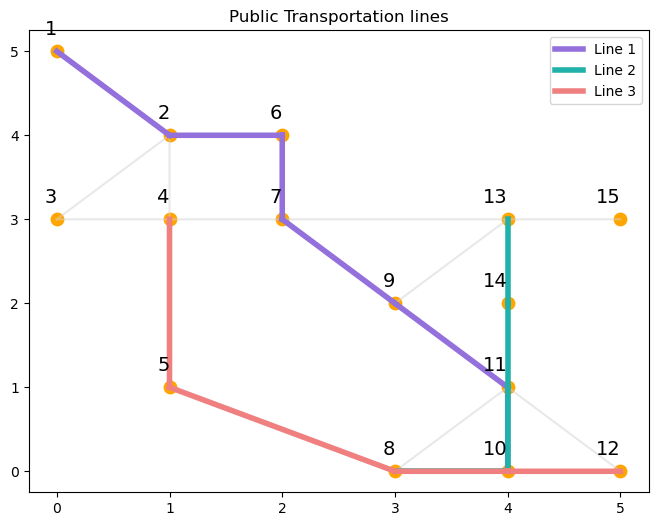

In [10]:
# Define lines_dict with nodes belonging to specific lines
lines_dict = {
    'Line1': [1, 2, 6, 7, 9, 11, 10],
    'Line2': [8, 10, 11, 14, 13],
    'Line3': [4, 5, 8, 10, 12]
}

# Initial values for the Headway of the Public transportation 

""" Headway is one of the decision variables of the model.
  Thus as the initial values we put the value to "ZERO" """ 

HEADWAY = {'Line1' :5, 
           'Line2': 5,
           'Line3': 5}  # Min

# ======================================================================
node_x = [pos[node][0] for node in pos]
node_y = [pos[node][1] for node in pos]
    
# Create edge traces
edge_x = []
edge_y = []

for edge in G_ver01.edges():
    # Get the coordinate of the starting node of the edge 
    x0, y0 = pos[edge[0]]
    # Get the coordinate of the ending node of the edge 
    x1, y1 = pos[edge[1]]

    # Let's make a list of these coordination of starting and eding nodes. we will need this list 
    edge_x.append(x0)  # Append the x-coordinate of the starting node to the edge_x list
    edge_y.append(y0)  # Append the y-coordinate of the starting node to the edge_y list
    edge_x.append(x1)  # Append the x-coordinate of the ending node to the edge_x list
    edge_y.append(y1)  # Append the y-coordinate of the ending node to the edge_y list

    """ These is a very very important point to consider here: The next lines add None to the edge_x and edge_y lists.
    Why?: None is used here as a way to break the line between two edges when plotting. In matplotlib, if there is a None value between two points, 
    it will break the line, meaning that the edge will be drawn as a separate segment and not connected to the next one.
    Without these None values, all edges would be drawn as continuous lines without breaks, potentially making the plot messy or confusing. """

    edge_x.append(None)  # Break between edges (None acts as a separator in plotting)
    edge_y.append(None)  # Break between edges (None acts as a separator in plotting)

# ======================================================================
# Visualization of the public transportation lines 
plt.figure(figsize=(8, 6))
plt.scatter(node_x, node_y, c='orange', s=80, edgecolors='orange')  # Nodes as blue dots

for node, (x, y) in pos.items():
    plt.text(x, y+0.2, str(node), fontsize=14, ha='right')  # Add labels near each node

# Draw edges
plt.plot(edge_x, edge_y, color='lightgrey', alpha=0.5)  # Plot edges with gray color

color = ["mediumpurple", "lightseagreen", "lightcoral"]
line_labels = ["Line 1", "Line 2", "Line 3"]

for line_index, line in enumerate(lines_dict):
    path = lines_dict[line]
    path_x = []  # Reset path_x for each line
    path_y = []  # Reset path_y for each line
    
    for i in range(len(path) - 1):
        x0, y0 = pos[path[i]]
        x1, y1 = pos[path[i + 1]]
        
        path_x.extend([x0, x1, None])  
        path_y.extend([y0, y1, None])
    
    # Plot the path with the corresponding color
    plt.plot(path_x, path_y, color=color[line_index % len(color)], linewidth=4, label=line_labels[line_index % len(line_labels)])  # Set line width and label


plt.legend()

plt.title("Public Transportation lines")
plt.show()

# Initialization 

In [11]:
"""Initial values for the decision variables gonna be the same as the perivouse network"""
price_c = round(random.uniform(0.75, 3), 2)     # Toll for cars (per passage)
price_bs = round(random.uniform(0.3, 1),2) # Bike-sharing fare (per km)
price_pt = round(random.uniform(0.5, 3), 2)     # Public transport fare (per km)
price_bs_cb = round(random.uniform(0.05, 1.5), 2) # Bike-sharing fare in combined trips (per km)
price_pt_cb = round(random.uniform(0.35, 2), 2) # Public transportation fare in combined trips (per km)

print("tolls for cars:", price_c)
print("fare for bikes:", price_bs)
print("fare for public transportation:", price_pt)
print("fare for bikes in combined modes:", price_bs_cb)
print("fare for public transportation in combine dmodes:", price_pt_cb)

tolls for cars: 2.76
fare for bikes: 0.45
fare for public transportation: 1.6
fare for bikes in combined modes: 0.27
fare for public transportation in combine dmodes: 0.37


In [12]:
# Fleet size variables 
BS_fleet_bound = (5, 100)  # Range for bike-sharing fleet size
PT_fleet_bound = (1, 50)   # Range for public transport fleet size

# Bike-sharing fleet size (integers within the specified range)
Fleet_bike = {}
for i in G_ver01.nodes():
    Fleet_bike[i] = random.randint(BS_fleet_bound[0], BS_fleet_bound[1])

# Public Transportation fleet size (integers within the specified range)
Fleet_public = {}
for line in lines_dict:
    Fleet_public[line] = random.randint(PT_fleet_bound[0], PT_fleet_bound[1])
number_bike_ver01 = Fleet_bike
number_public_ver01 = Fleet_public

print("number of bikes per station:", number_bike_ver01)
print("Number of public trasnportation per line:",number_public_ver01 )

number of bikes per station: {1: 17, 2: 33, 3: 24, 6: 88, 4: 49, 7: 54, 5: 72, 8: 95, 13: 49, 9: 74, 11: 19, 10: 20, 12: 57, 14: 81, 15: 7}
Number of public trasnportation per line: {'Line1': 25, 'Line2': 45, 'Line3': 41}


In [13]:
# Initial traffic flow per link for public transportion based on the frequency 
def initial_traffic_flow_link(G_ver01):

   # Define a dictionary for traffic flow on each link per mode
    xa = {}

    for i, j in G_ver01.edges():
        xa[(i,j)] = 0
        
    return xa
# =====================================================================
def initial_deman_mode (all_paths): # Travelers Deamnd per origin and destination 

    # Define a dictionary for the demand per origin and destination

    qw_c = {} # Demand of "Cars" per origin and destination 
    for origin, destination in all_paths: 
        if (origin, destination) not in qw_c:
            qw_c[(origin, destination)] = 0

    return qw_c
# ======================================================================
# Initial traffic flow per link for public transportion based on the frequency 
def initial_traffic_flow_pt_link(all_paths, HEADWAY):

    xa = {}

    for route_info_list in all_paths.values():
        for route in route_info_list:

            # Get the road
            route = route
            links = [(route[i], route[i + 1]) for i in range(len(route) - 1)]

            # Check whether the link is in the route or not
            for link in links:
                current_node = link[0]
                next_node = link[1]

                # Check if the current node and the next node exist in the route
                if current_node in route and next_node in route:
                    # Check if the next node comes after the current node in the route
                    if route.index(next_node) > route.index(current_node):

                        # Get the value of the line to calculate the traffic flow of the public transportation 
                        xa[(current_node, next_node)] = 0  # Initialize for the current link
                        total_headway_sum = 0  # Accumulate headway values for matching lines                           
                        # Loop through lines_dict to find all matching lines
                        for line, values in lines_dict.items():
                            if all(link_s in values for link_s in links):  # Check if all links in link_list are in the current line's values
                                line_headway = HEADWAY.get(line, 0)  # Get the headway for the matching line, default to 0 if not found
                                total_headway_sum += line_headway  # Add the headway value to the total sum

                        # Store the result in yapt for the link
                        xa[(current_node, next_node)] = total_headway_sum 

    return xa
# ======================================================================
def initial_passenger_link(all_paths, fp):

    ya = {}

    for key, route_list_info in all_paths.items():
        for route in route_list_info : 
            route = route # Etract the route 

            for i in range(len(route)-1):

                link = (route[i], route[i + 1])

                if link not in ya: 
                    ya[link] = 0 

                # Check if the route exists in fp
                fp_key = (key[0], key[1], tuple(route))  # Construct the fp key
                if fp_key in fp:
                    # Add the passenger flow of this route to the link
                    ya[link] += fp[fp_key]

    return ya
# ======================================================================
def initial_no_passenger_road(all_paths):
    fp_c = {}
    
    for (origin, destination), route_info_list in all_paths.items():
        for route in route_info_list:
            route = route
            if route is not None:  # Ensure the route exists
            
                route_tuple = tuple(route)
                if (origin, destination, route_tuple) not in fp_c:
                    fp_c[(origin, destination, route_tuple)] = 0
    return fp_c
# ===========================================================================
def update_all_or_nothing (all_paths, all_path_dict, fpw, qw_new):
    for od_pair in all_paths.keys():
        origin, destiantion = od_pair
        
        short_route = all_path_dict[origin][destiantion]
        for key in fpw:
            if key[0] == origin and key[1] == destiantion and tuple(short_route) == key[2]:
                fpw[key] = qw_new[od_pair]
    return fpw
# ======================================================================
def update_flows_msa(current_flows, new_flows, iteration):

    step_size = 1 / (iteration + 1)
    updated_flows = {key: (1 - step_size) * current_flows.get(key, 0) + step_size * new_flow
                     for key, new_flow in new_flows.items()}
    return updated_flows
# ======================================================================
def update_demand_on_fp_car(fp_c, qw_c, all_paths):

    for key in qw_c.keys():
        total_flow = 0
        
        for route in all_paths.get(key, []):
            total_flow += fp_c.get((key[0], key[1], tuple(route)), 0)  # If the route is not in fp_c, default to 0
        
        qw_c[key] = total_flow

    return qw_c
# =========================================================================================================================
def update_headway(fp_pt, lines_dict, HEADWAY):
    # Initialize passenger count for each line
    line_passengers = {line: 0 for line in lines_dict}

    # Aggregate passenger flow for each line
    for key, flow in fp_pt.items():
        origin, destination, route = key
        for line, segments in lines_dict.items():
            # Check if any segment in the route is part of the line's segments
            if any(segment in segments for segment in route):
                line_passengers[line] += flow  # Add flow to the line

    # Update headway based on passenger flow (inverse proportionality)
    for line, passengers in line_passengers.items():
        
        HEADWAY[line] = passengers / 15  # Example: headway is inversely proportional to passenger flow
        if HEADWAY[line] > 20: 
            HEADWAY[line] = 20 
        else:
            HEADWAY[line] = 5
    return HEADWAY
# ========================================================================================================================================
xa_c = initial_traffic_flow_link(G_ver01)
xa_bs = initial_traffic_flow_link(G_ver01)
xa_pt = initial_traffic_flow_pt_link(all_paths, HEADWAY)
f_car = initial_no_passenger_road(all_paths)

print("Cars' traffic flow:", xa_c)

Cars' traffic flow: {(1, 2): 0, (2, 3): 0, (2, 6): 0, (2, 4): 0, (3, 4): 0, (6, 7): 0, (4, 7): 0, (4, 5): 0, (7, 13): 0, (7, 9): 0, (5, 8): 0, (8, 11): 0, (8, 10): 0, (13, 9): 0, (13, 14): 0, (13, 15): 0, (9, 11): 0, (11, 10): 0, (11, 12): 0, (11, 14): 0, (10, 12): 0}


# Utility Functions

In [14]:
# =========================================================================================================================
# Car TraveL Time 
def travel_time_car(link, FREE_FLOW_TRAVEL_TIME, ca, xa_c):

    # Initialize the travel time to 0
    travel_time_car = 0

    # Check if the link exists in the xac dictionary
    if tuple(link) in xa_c:
        # Retrieve the traffic flow for the current link from the xac dictionary
       flow_value = xa_c[tuple(link)]
    else:
        # If the link is not found in xac, set the flow value to 0 (or handle accordingly)
        flow_value = 0

    # Retrieve the free-flow travel time for the current link from the FREE_FLOW_TRAVEL_TIME DataFrame
    # Note: assuming the FREE_FLOW_TRAVEL_TIME is a DataFrame where rows and columns are indexed from 1
    free_flow_time = (FREE_FLOW_TRAVEL_TIME.iloc[link[0]-1, link[1]-1])/60
    
    # Calculate the travel time for the current link using the given formula
    travel_time_car += free_flow_time * (1 + 0.15 * ((flow_value / ca) ** 4))

    return travel_time_car
def utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G):
    # Precompute travel times and pricing costs for all edges
    edge_weights = {}
    
    for edge in G.edges():
        travel_time = travel_time_car(edge, FREE_FLOW_TRAVEL_TIME, ca, xa_c)
        pricing = THE_LENGTH.loc[edge[0], edge[1]] * price_c
        edge_weights[edge] = (travel_time * travel_time_value_car) + pricing

    # Bulk update edge weights instead of looping inside
    nx.set_edge_attributes(G, {edge: {'weight_car': round(weight, 2)} for edge, weight in edge_weights.items()})

    # Compute shortest path utilities for all origins-destinations
    car_utility = {od: float('inf') for od in all_paths.keys()}  # Default value if no path exists

    for (origin, destination) in all_paths.keys():
        try:
            car_utility[(origin, destination)] = nx.dijkstra_path_length(G, source=origin, target=destination, weight='weight_car')
        except nx.NetworkXNoPath:
            pass  # Keep default 'inf' value

    return car_utility
# =========================================================================================================================
# Bike-sharing travel time 
def travel_time_bs(link, THE_LENGTH, vb):
    
    # In-vehicle Travel Time 
    travel_time_bs = (
        THE_LENGTH.loc[link[0], link[1]] / vb
    )   # Get the travel time of the bike-sharing 

    # Waiting Time
    waiting_time_bs_origin = 0.016666666666666666/P[link[0]][0]
    waiting_time_bs_destination = 0.001388888888888889
    
    return travel_time_bs + waiting_time_bs_origin + waiting_time_bs_destination


def utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G):
    
    # Precompute travel times and pricing costs for all edges
    edge_weights = {}

    for edge in G.edges():
        travel_time = travel_time_bs(edge, THE_LENGTH, vb)
        pricing = THE_LENGTH.loc[edge[0], edge[1]] * price_bs
        edge_weights[edge] = (travel_time * travel_time_value_bike) + pricing

    # Bulk update edge weights instead of looping inside
    nx.set_edge_attributes(G, {edge: {'weight_bike': round(weight, 2)} for edge, weight in edge_weights.items()})

    # Compute shortest path utilities for all origins-destinations
    bike_utility = {od: float('inf') for od in all_paths.keys()}  # Default value if no path exists

    for (origin, destination) in all_paths.keys():
        try:
            bike_utility[(origin, destination)] = nx.dijkstra_path_length(G, source=origin, target=destination, weight='weight_bike')
        except nx.NetworkXNoPath:
            pass  # Keep default 'inf' value

    return bike_utility

# =========================================================================================================================
# Public Transportation Travel Time
def travel_time_public(link, THE_LENGTH, lines_dict, vp, HEADWAY):
    
    travel_time_pt = (
        THE_LENGTH.loc[link[0], link[1]] / vp
    )   # Get the travel time of the bike-sharing 
    
    # Waiting Times                 
    waiting_time = 0  # Initialize waiting time for each route
    for line_id, line_route in lines_dict.items():
        for node in range(len(line_route)-1): 
            if line_route[node] == link[0] and line_route[node+1] == link[1]:
                hl = HEADWAY[line_id]  
                waiting_time = (hl / 2)/60  # Average waiting time (hr)
                

    return travel_time_pt + waiting_time # hr

#     return public_utility
def utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G, lines_dict, HEADWAY):
    # Compute edge weights in bulk
    edge_weights = {
        edge: (travel_time_public(edge, THE_LENGTH, lines_dict, vp, HEADWAY) * travel_time_value_public) +
              (THE_LENGTH.loc[edge[0], edge[1]] * price_pt)
        for edge in G.edges()
    }

    # Batch update edge attributes (avoiding slow per-edge updates)
    nx.set_edge_attributes(G, {edge: {'weight_public': round(weight, 2)} for edge, weight in edge_weights.items()})

    # Compute shortest path utilities
    public_utility = {}
    for origin, destination in all_paths.keys():
        try:
            public_utility[(origin, destination)] = nx.dijkstra_path_length(G, source=origin, target=destination, weight='weight_public')
        except nx.NetworkXNoPath:
            public_utility[(origin, destination)] = float('inf')  # If no path exists, store 'inf'

    return public_utility

# =========================================================================================================================

def utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, price_bs_cb, price_pt_cb):

    travel_time_dict = {} 
    
    # Iterate over each origin-destination pair
    for (origin, destination) in all_paths:
        total_time = 0
        pricing_bs = 0
        pricing_pt = 0

        # Ensure the key exists in the dictionary before accessing it
        if all_paths_with_modes_cb.get(origin, {}).get(destination):
            path = all_paths_with_modes_cb[origin][destination]["path"]
            modes = all_paths_with_modes_cb[origin][destination]["modes"]  # List of modes
            
            # Iterate over edges and compute costs
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                mode = modes[i]  # Mode for the current segment
                
                # Compute travel time and pricing based on the mode
                if mode == "bike":
                    total_time += travel_time_bs(edge, THE_LENGTH, vb)
                    pricing_bs += THE_LENGTH.loc[edge[0], edge[1]] * price_bs_cb
                elif mode == "public":
                    total_time += travel_time_public(edge, THE_LENGTH, lines_dict, vp, HEADWAY)
                    pricing_pt += THE_LENGTH.loc[edge[0], edge[1]] * price_pt_cb
            
            # Store the total travel time for the origin-destination pair
            travel_time_dict[(origin, destination)] = (total_time * travel_time_value_combined) + pricing_bs + pricing_pt
        else:
            # If no valid path exists, assign infinity as the travel time
            travel_time_dict[(origin, destination)] = float('inf')

    return travel_time_dict  # Returns cost in Euro
# =========================================================================================================================

# Shortest path 

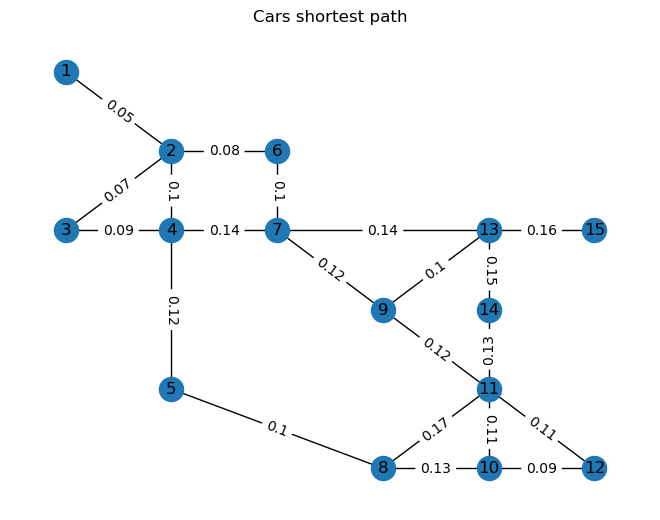

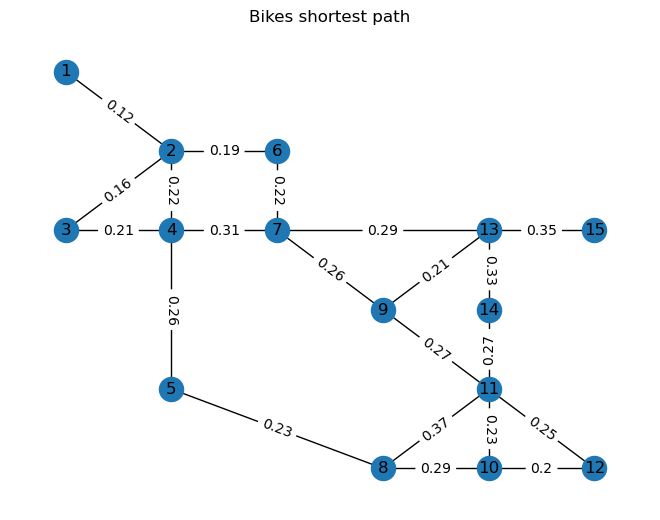

In [15]:
# CAR SHORTEST PATH ========================================================================================================
# Compute the weigths for all links of the network/graph For CARS
for i, j in G_ver01.edges():
    G_ver01[i][j]["weight"] = round(travel_time_car([i,j], FREE_FLOW_TRAVEL_TIME, ca, xa_c), 2)

# Draw the weighted graph
nx.draw(G_ver01, pos, with_labels=True)
labels = nx.get_edge_attributes(G_ver01, 'weight')
nx.draw_networkx_edge_labels(G_ver01, pos, edge_labels=labels)
plt.title("Cars shortest path")
plt.show()

all_paths_car  = nx.all_pairs_dijkstra_path(G_ver01, weight='weight')

# Convert to a dictionary (optional)
all_paths_dict_car = dict(all_paths_car)
# =========================================================================================================================
# Compute the weigths for all links of the network/graph For BIKES
for i, j in G_ver01.edges():
    G_ver01[i][j]["weight"] = round(travel_time_bs([i,j], THE_LENGTH, vb),2)

# Draw the weighted graph
nx.draw(G_ver01, pos, with_labels=True)
labels = nx.get_edge_attributes(G_ver01, 'weight')
nx.draw_networkx_edge_labels(G_ver01, pos, edge_labels=labels)
plt.title("Bikes shortest path")
plt.show()

# Compute the shortest path between all nodes in a weighted network/graph : For BIKES
# Compute shortest paths for all pairs of nodes
all_paths_bs  = nx.all_pairs_dijkstra_path(G_ver01, weight='weight')

# Convert to a dictionary (optional)
all_paths_dict_bs = dict(all_paths_bs)
# =========================================================================================================================

Shortest path for public transport: [[1, 2, 6, 7, 9, 11, 10, 8]]


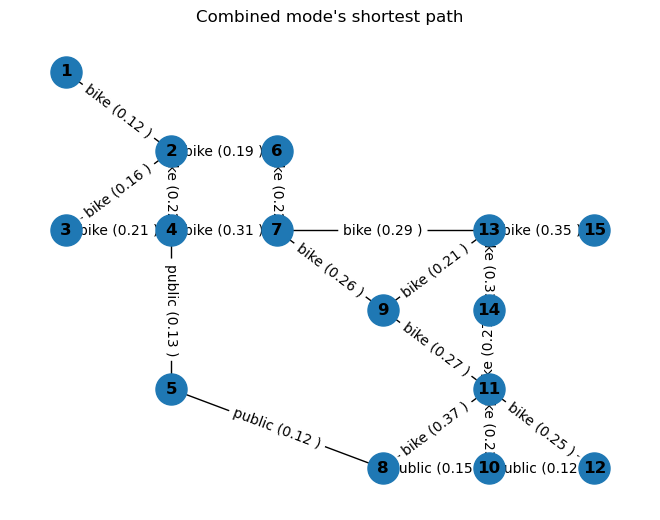

In [16]:
# Compute the weigths for all links of the network for PUBLIC TRANSPORTATION
valid_edges = set()
for line_nodes in lines_dict.values():
    valid_edges.update((line_nodes[i], line_nodes[i + 1]) for i in range(len(line_nodes) - 1))
    valid_edges.update((line_nodes[i + 1], line_nodes[i]) for i in range(len(line_nodes) - 1))  # Include reverse edges

# Generate all paths and filter based on valid edges
all_path_dict_pt = {}

for i in G_ver01.nodes():
    for j in G_ver01.nodes():
        if i != j:  # Avoid self-loops
            # Generate all simple paths between node i and node j
            all_paths_possible = list(nx.all_simple_paths(G_ver01, source=i, target=j))
            
            # Filter paths where all edges belong to valid_edges
            valid_paths = [
                path for path in all_paths_possible
                if all((path[k], path[k + 1]) in valid_edges for k in range(len(path) - 1))
            ]
            
            # Store the filtered paths
            if valid_paths:  # Only include if there are valid paths
                all_path_dict_pt[(i, j)] = valid_paths

# Display filtered paths
print("Shortest path for public transport:", all_path_dict_pt[(1,8)])
# =========================================================================================================================
# COMBINED MODES SHORTEST PATH 
# Compute the shortest path between all nodes in a weighted network/graph : For COMBINED MODE
for line_index, line in enumerate(lines_dict):
    path = lines_dict[line]
    for i, j in G_ver01.edges():
        bs_time = travel_time_bs([i,j], THE_LENGTH, vb)
        pt_time = travel_time_public([i,j], THE_LENGTH, lines_dict, vp, HEADWAY)
        if i in path and j in path:
            if bs_time < pt_time:
                G_ver01[i][j]["mode"] = "bike"
                G_ver01[i][j]["travel_time"] = bs_time
            else:
                G_ver01[i][j]["mode"] = "public"
                G_ver01[i][j]["travel_time"] = pt_time
        else: 
            G_ver01[i][j]["travel_time"] = bs_time
            G_ver01[i][j]["mode"] = "bike"

# Draw nodes and edges
nx.draw(G_ver01, pos, with_labels=True, node_size=500, font_weight='bold')

# Create edge labels that display mode and travel time
edge_labels = {
    (i, j): f"{G_ver01[i][j]['mode']} ({G_ver01[i][j]['travel_time']:.2f} )"
    for i, j in G_ver01.edges()
}
nx.draw_networkx_edge_labels(G_ver01, pos, edge_labels=edge_labels)

plt.title("Combined mode's shortest path")
plt.show()

In [17]:
#Combined modes shortest path dictionary 
# Compute shortest paths for all pairs of nodes
all_paths_cb  = nx.all_pairs_dijkstra_path(G_ver01, weight='travel_time')

# Convert to a dictionary 
all_paths_dict_cb = dict(all_paths_cb)

# Create a new dictionary to store paths with modes
all_paths_with_modes_cb = {}

# Process each shortest path and add mode information
for source, paths in all_paths_dict_cb.items():
    all_paths_with_modes_cb[source] = {}  # Initialize dictionary for this source
    for target, path in paths.items():
        if source == target:  # Skip paths from a node to itself
            continue
        
        modes = []  # List to store modes along the path
        for i in range(len(path) - 1):  # Iterate over consecutive pairs of nodes
            u, v = path[i], path[i+1]  # Get the edge (u, v)
            mode = G_ver01[u][v]['mode']     # Retrieve the mode from edge attributes
            modes.append(mode)         # Add mode to the list

        # Store both the path and the modes in the new dictionary
        all_paths_with_modes_cb[source][target] = {
            'path': path,
            'modes': modes
        }

# Print the shortest paths with modes (excluding same-node paths)
print("\nShortest paths between all node pairs for COMBINED MODE with Modes:")
for source, targets in all_paths_with_modes_cb.items():
    for target, details in targets.items():
        path = details['path']
        modes = details['modes']
        print(f"Shortest path from {source} to {target}: {path}")
        print(f"  Modes: {modes}")


Shortest paths between all node pairs for COMBINED MODE with Modes:
Shortest path from 1 to 2: [1, 2]
  Modes: ['bike']
Shortest path from 1 to 3: [1, 2, 3]
  Modes: ['bike', 'bike']
Shortest path from 1 to 6: [1, 2, 6]
  Modes: ['bike', 'bike']
Shortest path from 1 to 4: [1, 2, 4]
  Modes: ['bike', 'bike']
Shortest path from 1 to 7: [1, 2, 6, 7]
  Modes: ['bike', 'bike', 'bike']
Shortest path from 1 to 5: [1, 2, 4, 5]
  Modes: ['bike', 'bike', 'public']
Shortest path from 1 to 8: [1, 2, 4, 5, 8]
  Modes: ['bike', 'bike', 'public', 'public']
Shortest path from 1 to 13: [1, 2, 6, 7, 13]
  Modes: ['bike', 'bike', 'bike', 'bike']
Shortest path from 1 to 9: [1, 2, 6, 7, 9]
  Modes: ['bike', 'bike', 'bike', 'bike']
Shortest path from 1 to 11: [1, 2, 4, 5, 8, 11]
  Modes: ['bike', 'bike', 'public', 'public', 'bike']
Shortest path from 1 to 10: [1, 2, 4, 5, 8, 10]
  Modes: ['bike', 'bike', 'public', 'public', 'public']
Shortest path from 1 to 12: [1, 2, 4, 5, 8, 10, 12]
  Modes: ['bike', 'bi

In [18]:
"""Having the shortest path and the travel time we can calculate the utility function of each mode"""
print("Utility of cars:", utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G_ver01))
print("Utility of bikes:", utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G_ver01))
print("Utility of public transport:", utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G_ver01, lines_dict, HEADWAY))
print("Utility of combined modes:", utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                                                          HEADWAY, travel_time_value_combined, price_bs_cb,price_pt_cb))

Utility of cars: {(1, 2): 5.84, (1, 3): 14.01, (1, 6): 15.57, (1, 4): 17.52, (1, 7): 27.25, (1, 5): 31.14, (1, 8): 43.21, (1, 13): 43.21, (1, 9): 41.65, (1, 11): 55.66, (1, 10): 58.78, (1, 12): 68.89999999999999, (1, 14): 61.120000000000005, (1, 15): 62.28, (2, 1): 5.84, (2, 3): 8.17, (2, 6): 9.73, (2, 4): 11.68, (2, 7): 21.41, (2, 5): 25.299999999999997, (2, 8): 37.37, (2, 13): 37.370000000000005, (2, 9): 35.81, (2, 11): 49.82, (2, 10): 52.94, (2, 12): 63.06, (2, 14): 55.28, (2, 15): 56.440000000000005, (3, 1): 14.01, (3, 2): 8.17, (3, 6): 17.9, (3, 4): 10.9, (3, 7): 27.25, (3, 5): 24.52, (3, 8): 36.59, (3, 13): 43.21, (3, 9): 41.65, (3, 11): 55.66, (3, 10): 52.160000000000004, (3, 12): 63.06, (3, 14): 61.120000000000005, (3, 15): 62.28, (6, 1): 15.57, (6, 2): 9.73, (6, 3): 17.9, (6, 4): 21.41, (6, 7): 11.68, (6, 5): 35.03, (6, 8): 47.1, (6, 13): 27.64, (6, 9): 26.08, (6, 11): 40.089999999999996, (6, 10): 52.55, (6, 12): 53.33, (6, 14): 45.55, (6, 15): 46.71, (4, 1): 17.52, (4, 2): 11

# Logit function 

In [19]:
def logit_mode_choice(Demand, all_paths, utilities_functions):

    utilities = {mode: func() for mode, func in utilities_functions.items()}
    results = {mode: {} for mode in utilities_functions}

    for (origin, destination) in all_paths:
        qw = Demand[origin][destination]

        # Compute mode-specific exponentials
        exp_utilities = {
            mode: np.exp(- 0.1* utilities[mode].get((origin, destination), 0))
            for mode in utilities
        }

        denominator = sum(exp_utilities.values())

        # Store results for each mode
        for mode in utilities:
            results[mode][(origin, destination)] = qw * (exp_utilities[mode] / denominator)

    return results['car'], results['bike_sharing'], results['public_transport'], results['combined']

In [20]:
"""To check if the logit model and the utility functions alight we will print the values by considering the pricing to zero"""

price_bs = 0 
price_bs_cb = 0
price_pt = 0 
price_c = 0
price_pt_cb = 0

utilities_functions = {
        'car': lambda: utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G_ver01),
        'bike_sharing': lambda: utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G_ver01),
        'public_transport': lambda: utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G_ver01, lines_dict, HEADWAY),
        'combined': lambda: utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, price_bs_cb, price_pt_cb)
    }

qw_c = logit_mode_choice(Demand, all_paths, utilities_functions)[0]  # Demand for Car
qw_bs = logit_mode_choice(Demand, all_paths, utilities_functions)[1]  # Demand for Bike_sharing
qw_pt = logit_mode_choice(Demand, all_paths, utilities_functions)[2]  # Demand for Public transportaion
qw_cb = logit_mode_choice(Demand, all_paths, utilities_functions)[3]  # Demand for Combined mode

print("Utility of cars:", utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G_ver01))
print("Utility of bikes:", utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G_ver01),)
print("Utility of public transport:", utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G_ver01, lines_dict, HEADWAY))
print("Utility of combined modes:", utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, price_bs_cb, price_pt_cb))
print("==================================================================================")
print("Modal shre of cars:",qw_c )
print("Modal shre of bikes:",qw_bs )
print("Modal shre of public trasnportation:",qw_pt )
print("Modal shre of combined modes:",qw_cb )

Utility of cars: {(1, 2): 1.7, (1, 3): 4.08, (1, 6): 4.53, (1, 4): 5.1, (1, 7): 7.93, (1, 5): 9.059999999999999, (1, 8): 12.569999999999999, (1, 13): 12.57, (1, 9): 12.120000000000001, (1, 11): 16.200000000000003, (1, 10): 17.099999999999998, (1, 12): 20.050000000000004, (1, 14): 17.78, (1, 15): 18.12, (2, 1): 1.7, (2, 3): 2.38, (2, 6): 2.83, (2, 4): 3.4, (2, 7): 6.23, (2, 5): 7.359999999999999, (2, 8): 10.87, (2, 13): 10.870000000000001, (2, 9): 10.420000000000002, (2, 11): 14.500000000000002, (2, 10): 15.399999999999999, (2, 12): 18.35, (2, 14): 16.080000000000002, (2, 15): 16.42, (3, 1): 4.08, (3, 2): 2.38, (3, 6): 5.21, (3, 4): 3.17, (3, 7): 7.93, (3, 5): 7.13, (3, 8): 10.64, (3, 13): 12.57, (3, 9): 12.120000000000001, (3, 11): 16.200000000000003, (3, 10): 15.170000000000002, (3, 12): 18.340000000000003, (3, 14): 17.78, (3, 15): 18.12, (6, 1): 4.53, (6, 2): 2.83, (6, 3): 5.21, (6, 4): 6.23, (6, 7): 3.4, (6, 5): 10.190000000000001, (6, 8): 13.700000000000001, (6, 13): 8.04, (6, 9): 

# Visualizing the modal share 

In [21]:
def visualize_mode_choice_sumation(qw_c, qw_bs, qw_pt, qw_cb, all_paths):

    # Initialize total demand for each mode
    total_demand = [0, 0, 0, 0]  # [Car, Bike_sharing, Public Transport, Combined Mode]
    
    # Sum up the demand for each mode across all OD pairs
    for key in all_paths:  # Iterate over the keys (OD pairs)
        total_demand[0] += qw_c[key]
        total_demand[1] += qw_bs[key]
        total_demand[2] += qw_pt[key]
        total_demand[3] += qw_cb[key]
    
    # Define modes and colors
    modes = ["Car", "Bike Sharing", "Public Transportation", "Combined Mode"]
    colors = ["lightgray", "mediumseagreen", "paleturquoise", "thistle"]
    
    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(modes, total_demand, color=colors)
    plt.title("Total Mode Choice Across All OD Pairs", fontsize=14)
    plt.ylabel("Total Demand", fontsize=12)
    plt.xlabel("Mode", fontsize=12)
    
    # Add values above the bars
    for i, value in enumerate(total_demand):
        plt.text(i, value + 0.02 * max(total_demand), f"{value:.2f}", ha='center', fontsize=10)
    
    # Show the plot
    plt.show()

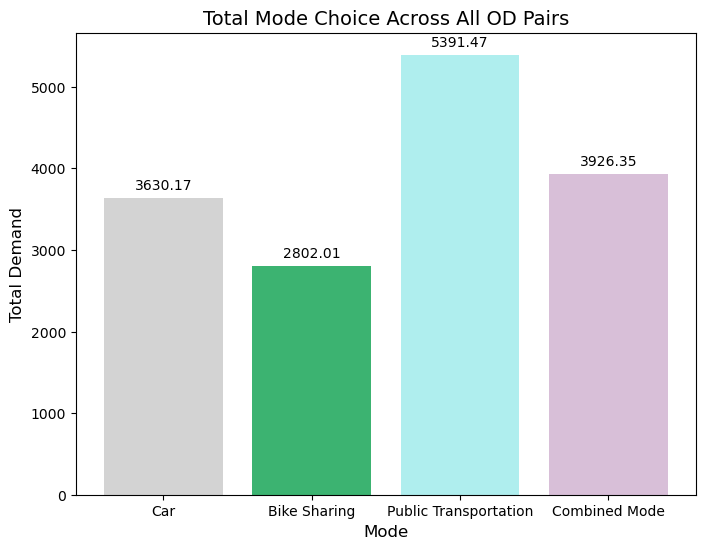

In [22]:
visualize_mode_choice_sumation(qw_c, qw_bs, qw_pt, qw_cb, all_paths)

# Objective function

In [23]:
def operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                           price_bs_cb, price_pt_cb, Run_Cost_bike, lines_dict, number_bike_ver01, number_public_ver01, qw_c, 
                           qw_bs, qw_pt, qw_cb):
    
    first_term_bs_pt_c = first_term_combined = 0
    Second_term = 0
    XBS = 0
    XPT = 0

    for (origin, destination), ROUTE_LIST in all_paths.items():
        for ROUTE in ROUTE_LIST:
            route = ROUTE
            pricing_bs = pricing_pt = pricing_c =0

            for i in range(len(route) - 1):
                edge = route[i], route[i + 1]
                pricing_c += THE_LENGTH[edge[0]][edge[1]] * price_c
                pricing_bs += THE_LENGTH[edge[0]][edge[1]] * price_bs
                pricing_pt += THE_LENGTH[edge[0]][edge[1]] * price_pt

        first_term_bs_pt_c += (qw_bs[(origin, destination)] * pricing_bs) + (qw_pt[(origin, destination)] * pricing_pt) + (qw_c[(origin, destination)]) * pricing_c

    for origin, dest_dict in all_paths_with_modes_cb.items():
        for destination, data in dest_dict.items():
            path, modes = data["path"], data["modes"]
            for i in range(len(path) - 1):
                edge = path[i], path[i + 1]
                pricing_cb = sum(
                    THE_LENGTH.loc[edge[0]][edge[1]] * (price_bs_cb if mode == "bike" else price_pt_cb)
                    for i, mode in enumerate(modes))
            
            first_term_combined += qw_cb[(origin, destination)] * (2 * pricing_cb)
   
    for i, j in G_ver01.edges():
        XBS += xa_bs[i,j] * THE_LENGTH[i][j]
        XPT += xa_pt[i,j] * THE_LENGTH[i][j]

    NBS = 0 
    for i in G_ver01.nodes():
        NBS += number_bike_ver01[i]

    number_public_ver01 = {k: (v if v is not None else 0) for k, v in number_public_ver01.items()}
    n_pt = 0
    for line in lines_dict:
        n_pt += number_public_ver01.get(line, 0)
        
    Second_term = (Public_cost * n_pt) + (Bike_cost * NBS) + (Run_cost_public * XPT) + (Run_Cost_bike * XBS) # This is the cost per hour 

    return first_term_bs_pt_c + first_term_combined - Second_term

In [24]:
def consumer_surplus(Demand, all_paths, mu, utilities_functions):

    utilities = {mode: func() for mode, func in utilities_functions.items()}

    consumer_surplus_total = 0

    for (origin, destination) in all_paths:
        
        qw = Demand[origin][destination]

        exp_utilities = {
            mode: np.exp(utilities[mode].get((origin, destination), 0))
            for mode in utilities
        }
        
        # Ensure no value in exp_utilities is `float('inf')`
        if all(value != float('inf') for value in exp_utilities.values()):
            
            total_exp_utility = sum(exp_utilities.values())
    
            total_utility = np.log(total_exp_utility) if total_exp_utility > 0 else 0
    
            consumer_surplus_total += (qw / mu) * total_utility

    return consumer_surplus_total # Euro

In [25]:
def Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public,
                    F_public, I_public, social_co2, xa_bs, xa_pt, xa_c):
   
    climate_change = 0  
    XBS = 0
    XPT = 0
    XC = 0 

    for i, j in G_ver01.edges():
        XBS += xa_bs.get((i, j), 0) * THE_LENGTH[i][j]
        XPT += xa_pt.get((i, j), 0) * THE_LENGTH[i][j]
        XC += xa_c.get((i, j), 0) * THE_LENGTH[i][j]
        
    climate_change = ((XBS * (V_bike + F_bike + I_bike)) +        # Bike-sharing cost
           (XPT * (V_public + F_public + I_public)) +  # Public transport cost
           (XC * (V_car + F_car + I_Car))) * social_co2            # Car cost
    
    return climate_change #Euro

In [26]:
def Health_benefit (G_ver01, THE_LENGTH, xa_bs, HB, vb):
    
    Health_Benefit = 0  
    XBS = 0

    for i, j in G_ver01.edges():
        XBS += xa_bs.get((i, j), 0) * THE_LENGTH[i][j] * travel_time_bs([i,j], THE_LENGTH, vb)

    Health_Benefit = HB * XBS

    return Health_Benefit #Euro

In [27]:
mu = 0.1 
utilities_functions = {
        'car': lambda: utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G_ver01),
        'bike_sharing': lambda: utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G_ver01),
        'public_transport': lambda: utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G_ver01, lines_dict, HEADWAY),
        'combined': lambda: utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, price_bs_cb, price_pt_cb)
    }

print("Operator surplus:", operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                           price_bs_cb, price_pt_cb, Run_cost_bike, lines_dict, number_bike_ver01, number_public_ver01, qw_c, 
                           qw_bs, qw_pt, qw_cb))
print("Consumer surplus:", consumer_surplus(Demand, all_paths, mu, utilities_functions))
print("Climate change cost:", Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, xa_bs, xa_pt, xa_c))
print("Health benefit :", Health_benefit (G_ver01, THE_LENGTH, xa_bs, HB, vb))

Operator surplus: -3376.1589999999997
Consumer surplus: 1848206.6475969704
Climate change cost: 0.0
Health benefit : 0.0


# Constraints 

In [28]:
def Bike_Number_Constraint_ver01(qw_bs, qw_cb, all_paths, THE_LENGTH, vb):
    
    NBS = {}
    
    for node in G_ver01.nodes():
        NBS[node] = 0
    for (origin, destination) , ROUTE_LIST in all_paths.items():
        travel_time = 0
        for ROUTE in ROUTE_LIST:
            route_path = ROUTE
            for i in range(len(route_path)-1):
                edge = [route_path[i], route_path[i+1]]
                travel_time += travel_time_bs(edge, THE_LENGTH, vb)

        NBS[origin] += math.ceil((qw_cb[origin, destination] + qw_bs[origin, destination]) * travel_time)
                
    return NBS

In [29]:
def public_number_constraint(HEADWAY, lines_dict) :

    npt = {}
    
    for line_index, line in enumerate(lines_dict):
        path = lines_dict[line]
        total_time = 0
        
        for i in range(len(path) - 1):
            edge = [path[i], path[i + 1]]
            total_time += travel_time_public(edge, THE_LENGTH, lines_dict, vp, HEADWAY)
        
        if HEADWAY[line] != 0:
            npt[line] = math.ceil(total_time / HEADWAY[line])
        else:
            npt[line] = 0  
    
    return npt

In [30]:
print("Number of bikes per station:", Bike_Number_Constraint_ver01(qw_bs, qw_cb, all_paths, THE_LENGTH, vb))
print("Number of public trasnportation feelts per line:", public_number_constraint(HEADWAY, lines_dict))

Number of bikes per station: {1: 22463, 2: 20981, 3: 20651, 6: 50697, 4: 17129, 7: 15280, 5: 16504, 8: 27965, 13: 15589, 9: 6484, 11: 13215, 10: 100616, 12: 14375, 14: 7214, 15: 0}
Number of public trasnportation feelts per line: {'Line1': 1, 'Line2': 1, 'Line3': 1}


# Initial solution (GA)

In [31]:
def generate_population(pop_size, BS_fleet_bound, PT_fleet_bound, G_ver01, n_lines):
    num_nodes = len(G_ver01) if isinstance(G_ver01, list) else len(G_ver01.nodes())
    pop = np.zeros((pop_size, 5 + num_nodes + n_lines))
    
    pop[:, 0] = np.round(np.random.uniform(0.75, 3, pop_size), 2)  # Toll for cars
    pop[:, 1] = np.round(np.random.uniform(0.3, 1, pop_size), 2)   # Bike-sharing fare
    pop[:, 2] = np.round(np.random.uniform(0.5, 3, pop_size), 2)   # Public transport fare
    pop[:, 3] = np.round(np.random.uniform(0.05, 1.5, pop_size), 2)  # Combined bike-sharing fare
    pop[:, 4] = np.round(np.random.uniform(0.35, 2, pop_size), 2)   # Combined PT fare

    #pop[:, 0] = 0
    #pop[:, 1] = 0
    #pop[:, 2] = 0
    #pop[:, 3] = 0
    #pop[:, 4] = 0
    
    for i in range(num_nodes):
        pop[:, 5 + i] = np.random.randint(BS_fleet_bound[0], BS_fleet_bound[1] + 1, pop_size)
    
    for i in range(n_lines):
        pop[:, 5 + num_nodes + i] = np.random.randint(PT_fleet_bound[0], PT_fleet_bound[1] + 1, pop_size)
    
    return pop
# =========================================================================================================================
pop_size = 30
n_lines = 3 # Number of public transportaiton lines in the network
pop = generate_population(pop_size, BS_fleet_bound, PT_fleet_bound, G_ver01, n_lines)
print("The first solution:", pop[0])

The first solution: [ 2.83  0.53  2.77  0.28  1.41 70.   41.    9.   95.   86.   78.   86.
 89.   59.   95.   17.   83.   48.   28.   32.   10.   28.    3.  ]


# Fitness evaluation

In [32]:
individual = pop[0]
price_bs = individual[0]
price_pt = individual[1]
price_c = individual[2]
price_bs_cb = individual[3]
price_pt_cb = individual[4]
number_bike_list = individual[5:20]
number_bike = {}
for i, j in zip(G_ver01.nodes(), number_bike_list):  
    number_bike[i] = j
number_public_list = individual[20:23]
number_public = {}
for i, j in zip(number_public_list, lines_dict):
    number_public[j] = i

In [ ]:
def compute_fitness_ver01(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_Cost_bike, 
                    Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                    V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, 
                    Bike_Number_Constraint_ver01, public_number_constraint, 
                    qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c):
    
    OP = operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, individual[0], individual[1], individual[2], 
                                individual[3], individual[4], Run_Cost_bike, lines_dict, number_bike, number_public, 
                                qw_c, qw_bs, qw_pt, qw_cb)

    CS = consumer_surplus(Demand, all_paths, mu, {
        'car': lambda: utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, individual[2], G_ver01),
        'bike_sharing': lambda: utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, individual[0],G_ver01),
        'public_transport': lambda: utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, individual[0], G_ver01, lines_dict, HEADWAY),
        'combined': lambda: utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, individual[3], individual[4])})

    CC = Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, xa_bs, xa_pt, xa_c)
    HealthB =  Health_benefit(G_ver01, THE_LENGTH, xa_bs, HB, vb)

    OF = OP + CS + (-(CC) + HealthB)

    # Vectorized Constraint Checks
    no_bike = Bike_Number_Constraint_ver01(qw_bs, qw_cb, all_paths, THE_LENGTH, vb)
    no_pt = public_number_constraint(HEADWAY, lines_dict)

    no_bike_array = np.array([no_bike[i] for i in G_ver01.nodes()])
    number_bike_array = np.array([number_bike[i] for i in G_ver01.nodes()])
    OF -= 1000 * np.sum(no_bike_array > number_bike_array)

    no_pt_array = np.array([no_pt[line] for line in lines_dict])
    number_public_array = np.array([number_public[line] for line in lines_dict])
    OF -= 1000 * np.sum(no_pt_array > number_public_array)

    return -OF, OP, CS, CC, HealthB
# ==================================================================================
individual = pop[0]
compute_fitness_ver01(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike, 
                    Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                    V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01, 
                    public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)

(-5679682.221538465, 473930.902502892, 5219751.319035573, 0.0, 0.0)

In [34]:
# Compute fitness for all individuals (Sequential)
OF_values = []
for individual in pop:
    fitness, OP, CS, CC, HealthB = compute_fitness_ver01(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike, 
                                                         Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                                                         V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01, 
                                                         public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)
    OF_values.append(fitness)

OF_values = np.array(OF_values)

# Select parents

In [35]:
def select_parents(pop, OF_values, tournament_size=5, roulette_prob=0.3):
    if np.random.rand() < roulette_prob:  
        # Roulette Wheel Selection
        fitness = 1 / (np.array(OF_values) + 1e-6)  
        probabilities = fitness / fitness.sum()
        selected_indices = np.random.choice(len(pop), size=2, replace=True, p=probabilities)
        parent1, parent2 = pop[selected_indices[0]], pop[selected_indices[1]]
    else:
        # Tournament Selection
        def tournament_selection():
            selected_indices = np.random.choice(len(pop), size=tournament_size, replace=False)
            best_index_in_tournament = np.argmin([OF_values[i] for i in selected_indices])
            return selected_indices[best_index_in_tournament]  # Return index instead of individual
        
        index1, index2 = tournament_selection(), tournament_selection()
        parent1, parent2 = pop[index1], pop[index2]

    return [parent1, parent2]

# =========================================================================================================================
select_parents(pop, OF_values, tournament_size=5, roulette_prob=0.3)

[array([ 2.9 ,  0.62,  1.92,  1.28,  1.4 , 42.  , 43.  , 63.  , 58.  ,
         6.  , 19.  , 24.  , 24.  , 32.  , 30.  , 60.  , 62.  , 80.  ,
        93.  , 61.  ,  5.  , 27.  , 45.  ]),
 array([ 2.85,  0.41,  1.04,  0.11,  1.09, 94.  , 41.  , 13.  , 91.  ,
        44.  , 36.  , 51.  , 21.  , 43.  , 96.  , 60.  , 69.  , 17.  ,
        58.  , 69.  , 46.  , 27.  , 11.  ])]

# Crossover

In [36]:
def crossover(parent1, parent2):
    # random.seed(25)  # Set random seed for consistency
    
    # Define crossover points for each section
    pricing_start, pricing_end = 0, 5   # Pricing section (first 5 values)
    bs_start, bs_end = 5, 11            # Bike-sharing fleet section (next 15 values)
    pt_start, pt_end = 11,12          # Public transport fleet section (next 3 values)

    # Randomly choose crossover points within each section
    p_point = random.randint(pricing_start, pricing_end - 1)   # Crossover point for pricing
    bs_point1, bs_point2 = sorted(random.sample(range(bs_start, bs_end), 2))  # Crossover for bike-sharing fleet
    pt_point = random.randint(pt_start, pt_end - 1)  # Crossover point for public transport fleet

    # Create offspring by copying parents
    offspring1, offspring2 = parent1[:], parent2[:]

    # Pricing crossover (floating-point values)
    offspring1[pricing_start:p_point], offspring2[pricing_start:p_point] = (
        offspring2[pricing_start:p_point], offspring1[pricing_start:p_point]
    )

    # Bike-sharing fleet crossover (integer values)
    offspring1[bs_point1:bs_point2], offspring2[bs_point1:bs_point2] = (
        offspring2[bs_point1:bs_point2], offspring1[bs_point1:bs_point2]
    )

    # Public transport fleet crossover (integer values)
    offspring1[pt_start:pt_point], offspring2[pt_start:pt_point] = (
        offspring2[pt_start:pt_point], offspring1[pt_start:pt_point]
    )

    # Ensure fleet sizes remain integers
    offspring1 = [int(x) if isinstance(x, float) == False else x for x in offspring1]
    offspring2 = [int(x) if isinstance(x, float) == False else x for x in offspring2]

    return offspring1, offspring2
# =========================================================================================================================
parent1 = pop[0]
parent2 = pop[1]
offspring1, offspring2 = crossover(parent1, parent2)

print("Offspring 1:", offspring1)
print("Offspring 2:", offspring2)
print("parent 1:", parent1)
print("parent 2:", parent2)

Offspring 1: [2.09, 0.34, 2.17, 0.72, 1.41, 70.0, 41.0, 98.0, 95.0, 86.0, 78.0, 86.0, 89.0, 59.0, 95.0, 17.0, 83.0, 48.0, 28.0, 32.0, 10.0, 28.0, 3.0]
Offspring 2: [2.09, 0.34, 2.17, 0.72, 1.79, 6.0, 12.0, 98.0, 23.0, 83.0, 52.0, 41.0, 44.0, 94.0, 80.0, 43.0, 81.0, 39.0, 52.0, 20.0, 12.0, 6.0, 43.0]
parent 1: [ 2.09  0.34  2.17  0.72  1.41 70.   41.   98.   95.   86.   78.   86.
 89.   59.   95.   17.   83.   48.   28.   32.   10.   28.    3.  ]
parent 2: [ 2.09  0.34  2.17  0.72  1.79  6.   12.   98.   23.   83.   52.   41.
 44.   94.   80.   43.   81.   39.   52.   20.   12.    6.   43.  ]


# Mutation

In [37]:
def mutate(parent, BS_fleet_bound, PT_fleet_bound, max_mutation_factor):
    # random.seed(25)  # Set random seed for consistency

    # Mutation for Pricing values (first 5 values)
    pricing_start, pricing_end = 0, 5
    for i in range(pricing_start, pricing_end):
        mutation_amount = random.uniform(-max_mutation_factor, max_mutation_factor)
        parent[i] = round(max(parent[i] + mutation_amount, 0.01), 2)  # Ensure positive price

    # Mutation for Bike-sharing fleet size (values from 5 to 11)
    bs_start, bs_end = 5, 11
    for i in range(bs_start, bs_end):
        mutation_amount = random.randint(-5, 5)  # Mutate by small integer
        parent[i] = max(min(parent[i] + mutation_amount, BS_fleet_bound[1]), BS_fleet_bound[0])  # Ensure within bounds

    # Mutation for Public transport fleet size (values from 11 to 12)
    pt_start, pt_end = 11, 12
    for i in range(pt_start, pt_end):
        mutation_amount = random.randint(-2, 2)  # Mutate by small integer
        parent[i] = max(min(parent[i] + mutation_amount, PT_fleet_bound[1]), PT_fleet_bound[0])  # Ensure within bounds

    # Ensure fleet sizes are integers
    parent = [int(x) if isinstance(x, float) == False else x for x in parent]

    return parent
# =========================================================================================================================
mutated_offspring1 = mutate(parent1, BS_fleet_bound, PT_fleet_bound, max_mutation_factor=0.1)
print("Original Chromosome:", parent1)
print("Mutated Chromosome:", mutated_offspring1)

Original Chromosome: [  2.12   0.34   2.16   0.7    1.35  67.    44.   100.    94.    90.
  73.    50.    89.    59.    95.    17.    83.    48.    28.    32.
  10.    28.     3.  ]
Mutated Chromosome: [2.12, 0.34, 2.16, 0.7, 1.35, 67.0, 44.0, 100.0, 94.0, 90.0, 73.0, 50.0, 89.0, 59.0, 95.0, 17.0, 83.0, 48.0, 28.0, 32.0, 10.0, 28.0, 3.0]


# Traffic assignment & mode choice 

In [38]:
# Define valid public transport edges
valid_edges = set()
for line_nodes in lines_dict.values():
    valid_edges.update((line_nodes[i], line_nodes[i + 1]) for i in range(len(line_nodes) - 1))
    valid_edges.update((line_nodes[i + 1], line_nodes[i]) for i in range(len(line_nodes) - 1))

# Compute shortest paths for public transport considering only valid edges
shortest_paths_public = {}
for source in G_ver01.nodes():
    shortest_paths_public[source] = {}
    for target in G_ver01.nodes():
        if source != target:
            try:
                path = nx.shortest_path(G_ver01, source=source, target=target, weight='travel_time')
                if all((path[i], path[i + 1]) in valid_edges for i in range(len(path) - 1)):
                    shortest_paths_public[source][target] = {
                        "path": path,
                        "modes": ["public_transport"] * (len(path) - 1)  # Assign default mode
                    }
            except nx.NetworkXNoPath:
                pass  # No valid path found

# Store precomputed shortest paths for different modes
shortest_paths_car = nx.shortest_path(G_ver01, weight='weight_car')
shortest_paths_bike = nx.shortest_path(G_ver01, weight='weight_bike')

def traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca, 
                        travel_time_value_car, travel_time_value_bike, travel_time_value_public, 
                        travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car, 
                        travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01, 
                        utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing, 
                        update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road, 
                        initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway):
    
    # Initialize variables
    N = 5
    tolerance = 1e-3
    price_bs, price_pt, price_c, price_bs_cb, price_pt_cb = individual[:5]
    
    number_bike_list = individual[5:20]
    number_bike = {i: j for i, j in zip(G_ver01.nodes(), number_bike_list)}
    
    number_public_list = individual[20:23]
    number_public = {j: i for i, j in zip(number_public_list, lines_dict)}
    
    # Initial traffic and demand values
    fpw_c = initial_no_passenger_road(all_paths)
    HEADWAY = {line: 5 for line in lines_dict}
    xa_c = xa_bs = xa_pt = initial_traffic_flow_link(G_ver01)
    qw_c = initial_deman_mode(all_paths)
    
    # Cached travel times for efficiency
    travel_times_car = {}
    travel_times_bike = {}
    
    for (i, j) in G_ver01.edges():
        travel_times_bike[(i, j)] = round(travel_time_bs([i, j], THE_LENGTH, vb), 2)
        travel_times_car[(i, j)] = round(travel_time_car([i, j], FREE_FLOW_TRAVEL_TIME, ca, xa_c), 2)
    
    hp_c = {}
    
    for n in range(N):
        # Step 1: Compute shortest paths
        utilities_functions = {
        'car': lambda: utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, price_c, G_ver01),
        'bike_sharing': lambda: utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, price_bs, G_ver01),
        'public_transport': lambda: utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, price_pt, G_ver01, lines_dict, HEADWAY),
        'combined': lambda: utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, price_bs_cb, price_pt_cb)
    }

        # Step 2: Update demand using logit model
        qw_c_new, qw_bs, qw_pt, qw_cb = logit_mode_choice(Demand, all_paths, utilities_functions)

        # Step 3: Update traffic flow
        for origin, destination in all_paths:
            route_bs = np.array(shortest_paths_bike.get(origin, {}).get(destination, []))
            route_combined = np.array(shortest_paths_public.get(origin, {}).get(destination, {}).get("path", []))
            links_BS = set(zip(route_bs[:-1], route_bs[1:]))
            links_COMBINED = set(zip(route_combined[:-1], route_combined[1:]))
            common_links = links_BS & links_COMBINED
            
            for link in common_links:
                xa_bs[link] = qw_bs.get((origin, destination), 0) + qw_cb.get((origin, destination), 0)
            for link in links_BS - common_links:
                xa_bs[link] = qw_bs.get((origin, destination), 0)

        # Public transportation traffic flow update
        for origin, destination in all_paths:
            route_pt = shortest_paths_public.get(origin, {}).get(destination, {}).get("path", [])
            for i in range(len(route_pt) - 1):
                link = (route_pt[i], route_pt[i + 1])
                xa_pt[link] = qw_pt.get((origin, destination), 0) + qw_cb.get((origin, destination), 0)

        # Step 4: Update car traffic flow using all-or-nothing assignment
        hp_c = update_all_or_nothing(all_paths, shortest_paths_car, fpw_c, qw_c_new)
        
        # Step 5: Update passenger flow for cars
        #print(f"Before MSA: Car Demand = {sum(qw_c_new.values())}, Car Flow = {sum(fpw_c.values())}")

        fpw_c = update_flows_msa(fpw_c, hp_c, n)

        #print(f"After MSA: Car Demand = {sum(qw_c_new.values())}, Car Flow = {sum(fpw_c.values())}")

        qw_c = update_demand_on_fp_car(fpw_c, qw_c, all_paths)
        
        fpw_pt = {}
        for (origin, destination), route in all_path_dict_pt.items():
            fpw_pt[(origin, destination,  tuple(route[0]))] = qw_pt[(origin, destination)] + qw_cb[(origin, destination)]

        # Step 6: Update public transport headway
        HEADWAY = update_headway(fpw_pt, lines_dict, HEADWAY)
        
        # Step 7: Update traffic flow of links 
        xa_c = initial_passenger_link(all_paths, fpw_c)
        
        # Convergence check
        max_change = max(abs(qw_c_new.get(k, 0) - qw_c.get(k, 0)) for k in qw_c)
        if n > 2 and max_change < tolerance:
            break

    return fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY,

In [39]:
fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca, 
                        travel_time_value_car, travel_time_value_bike, travel_time_value_public, 
                        travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car, 
                        travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01, 
                        utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing, 
                        update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road, 
                        initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)

In [78]:
xa_c[(1,2)]

400.9500254360407

In [79]:
# Check for the congestion in the network
def congestion_car(FREE_FLOW_TRAVEL_TIME, ca, xa_c, THE_LENGTH):

    congestion = {}
    
    for (i, j) in G_ver01.edges():
        congestion[(i, j)] = xa_c[(i,j)] / ca

    return congestion 

In [80]:
congestion_car(FREE_FLOW_TRAVEL_TIME, ca, xa_c, THE_LENGTH)

{(1, 2): 0.6682500423934011,
 (2, 3): 0.20422621820945286,
 (2, 6): 0.5869157394848721,
 (2, 4): 0.512790242913825,
 (3, 4): 0.18185630220934898,
 (6, 7): 0.8253361816561288,
 (4, 7): 0.15543849020794603,
 (4, 5): 0.720326749866446,
 (7, 13): 0.05664671197095974,
 (7, 9): 0.9786626353053547,
 (5, 8): 0.6617125887170126,
 (8, 11): 0.03756584142873594,
 (8, 10): 0.6052584578198148,
 (13, 9): 0.30385477817047724,
 (13, 14): 0.03211261207326226,
 (13, 15): 0.0,
 (9, 11): 1.29852685564836,
 (11, 10): 1.3761798150104902,
 (11, 12): 0.14189009125686014,
 (11, 14): 0.10597124102124904,
 (10, 12): 0.14618654717664314}

# Genetic Algorithm 

In [42]:
def smooth(data, window_size=5):

    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_smoothed_fitness(best_fitness_over_time):

    smoothed_fitness = smooth(best_fitness_over_time, window_size=5)  # Adjust window_size for smoothness
    
    # Plot the smoothed fitness values
    plt.plot(smoothed_fitness, label='Smoothed Best Objective')
    plt.xlabel('Generation')
    plt.ylabel('Objective Value')
    plt.title('Smoothed Objective Value Over Generations')
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
def genetic_algorithm_ver02(initial_solution, G_ver01, population_size=10, iterations=15):


    population = initial_solution  # Initial population
    HEADWAY = {'Line1' :5, 'Line2': 5,'Line3': 5}
    best_fitness_over_time = []  # List to store best fitness values for each generation
    # =========================
    total_cars_over_time = []
    demand_car_over_time = []
    total_emission = []
    total_op = []
    total_cs = []
    total_hb = []
    # ==========================

    fitness_shift = 0  # Initialize fitness shift to keep fitness positive if necessary
    OF_values = []
    traffic_flows = []
    # Step 0: Initialization ==============================================================================================================================================================================================
    fpw_c = initial_no_passenger_road(all_paths)  # Initial value for number of passengers in route p between origin-destination pair w (Cars)
    
    xa_c = initial_traffic_flow_link(G_ver01)   # Initial value of car traffic flow on link "a" for Cars 
    xa_bs = initial_traffic_flow_link(G_ver01)  # Initial value of car traffic flow on link "a" for Bikes 
    xa_pt = initial_traffic_flow_link(G_ver01) # Initial value of car traffic flow on link "a" for Public transportation 
    qw_c = initial_deman_mode (all_paths)  # Initial value for cars' demand 
    
    N = 10
    # ================================================================================================
    # Evaluate fitness for the initial population to find the best initial solution
    for i in range(len(population)):
        individual = population[i]
        price_bs = individual[1]
        price_pt = individual[2]
        price_c = individual[0]
        price_bs_cb = individual[3]
        price_pt_cb = individual[4]
        number_bike_list = individual[5:20]
        number_bike = {}
        for i, j in zip(G_ver01.nodes(), number_bike_list):  
            number_bike[i] = j
        number_public_list = individual[20:23]
        number_public = {}
        for i, j in zip(number_public_list, lines_dict):
            number_public[j] = i

    
        fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca, 
                        travel_time_value_car, travel_time_value_bike, travel_time_value_public, 
                        travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car, 
                        travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01, 
                        utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing, 
                        update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road, 
                        initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)
        
        fitness, OP, CS, CC, HealthB = compute_fitness_ver01(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike, 
                                                             Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                                                             V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01, 
                                                             public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)

        OF_values.append(fitness)
        traffic_flows.append((xa_c, xa_bs, xa_pt, qw_c, qw_bs, qw_pt, qw_cb, fpw_c))  # Store traffic flows for this solution

    # Identify the initial best solution
    initial_best_index = np.argmin(OF_values)
    initial_best_solution = population[initial_best_index]
    initial_best_fitness = -OF_values[initial_best_index]
    initial_xa_c, initial_xa_bs, initial_xa_pt, initial_qw_c, initial_qw_bs, initial_qw_pt, initial_qw_cb, initial_fpw_c = traffic_flows[initial_best_index]
    
    initial_op =operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                                       price_bs_cb, price_pt_cb, Run_cost_bike, lines_dict, number_bike_ver01, number_public_ver01, initial_qw_c, 
                                       initial_qw_bs, initial_qw_pt, initial_qw_cb)
    
    initial_cs=consumer_surplus(Demand, all_paths, mu, utilities_functions)
    
    initial_cc=Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public,
                              F_public, I_public, social_co2, initial_xa_bs, initial_xa_pt, initial_xa_c) 
    
    initial_hb = Health_benefit (G_ver01, THE_LENGTH, initial_xa_bs, HB, vb)
    print(f'Initial Best Fitness (Maximized OF) = {initial_best_fitness}')
    
    # ================================================================================================
    # Evolution Process
    for generation in range(iterations):
        OF_values = []
        traffic_flows = []

        for i in range(len(population)):
            individual = population[i]
            price_bs = individual[1]
            price_pt = individual[2]
            price_c = individual[0]
            price_bs_cb = individual[3]
            price_pt_cb = individual[4]
            number_bike_list = individual[5:20]
            number_bike = {}
            for i, j in zip(G_ver01.nodes(), number_bike_list):  
                 number_bike[i] = j
            number_public_list = individual[20:23]
            number_public = {}
            for i, j in zip(number_public_list, lines_dict):
                number_public[j] = i


            N = 10
            fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca, 
                        travel_time_value_car, travel_time_value_bike, travel_time_value_public, 
                        travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car, 
                        travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01, 
                        utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing, 
                        update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road, 
                        initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)
            

            fitness, OP, CS, CC, HealthB = compute_fitness_ver01(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike, 
                                                             Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                                                             V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01, 
                                                             public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)


            OF_values.append(fitness)
            
        # Handle negative fitness values
        if min(OF_values) < 0:
            fitness_shift = abs(min(OF_values)) + 10
        else:
            fitness_shift = 0

        shifted_fitness_values = [fitness + fitness_shift for fitness in OF_values]

        # Identify the best solution for this generation
        best_index = np.argmin(OF_values)
        best_individual = population[best_index]
        best_fitness = -OF_values[best_index]
        best_fitness_over_time.append(best_fitness)
        
        price_c = best_individual[0]
        price_bs = best_individual[1]
        price_pt = best_individual[2]
        price_bs_cb = best_individual[3]
        price_pt_cb = best_individual[4]
        
        #final_xa_c, final_xa_bs, final_xa_pt, final_qw_c, final_qw_bs, final_qw_pt, final_qw_cb, final_fpw_c = traffic_flows[best_index]
        final_fpw_c, final_qw_c, final_qw_bs, final_qw_pt, final_qw_cb, final_xa_c, final_xa_bs, final_xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca, 
                        travel_time_value_car, travel_time_value_bike, travel_time_value_public, 
                        travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car, 
                        travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01, 
                        utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing, 
                        update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road, 
                        initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)
        
        final_op =operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                                       price_bs_cb, price_pt_cb, Run_cost_bike, lines_dict, number_bike_ver01, number_public_ver01, final_qw_c, 
                                       final_qw_bs, final_qw_pt, final_qw_cb)
        
        final_cs=consumer_surplus(Demand, all_paths, mu, utilities_functions)
        
        final_cc=Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public,
                                  F_public, I_public, social_co2, final_xa_bs, final_xa_pt, final_xa_c) 
        
        final_hb = Health_benefit (G_ver01, THE_LENGTH, final_xa_bs, HB, vb)
        print(f'Generation {generation + 1}: Best Fitness (Maximized OF) = {best_fitness}')
        # ========================================================================================================================================
        XC = 0
        XBS=0
        XPT=0
        for i, j in G_ver01.edges():
            XBS += final_xa_bs.get((i, j), 0) * THE_LENGTH[i][j]
            XPT += final_xa_pt.get((i, j), 0) * THE_LENGTH[i][j]
            XC += final_xa_c.get((i, j), 0)

        # print(f'Generation {generation + 1}: cilmate change cost car = {final_cc}')
        # print(f'Generation {generation + 1}: Number of cars  = {XC}')
        # print(f'Generation {generation + 1}: Demand Car = {sum(final_qw_c.values())}')

        demand_car_over_time.append(sum(final_qw_c.values()))  # Track car demand
        total_cars_over_time.append(XC)  # Track total car usage
        total_emission.append(final_cc)
        total_op.append(final_op)
        total_cs.append(final_cs)
        total_hb.append(final_hb)
        # ========================================================================================================================================
        # Elitism
        elite_size = max(1, int(0.1 * population_size))
        sorted_indices = np.argsort(OF_values)
        elite_individuals = [population[i] for i in sorted_indices[:elite_size]]

        new_population = elite_individuals

        # Dynamic mutation rate
        initial_mutation_rate = 0.1
        decay_rate = 0.1
        mutation_rate = initial_mutation_rate / (1 + decay_rate * generation)
        #print("mutation rate:",mutation_rate )
        # Generate new population
        while len(new_population) < population_size:
            parent1, parent2 = select_parents(population, shifted_fitness_values, tournament_size=5)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, BS_fleet_bound, PT_fleet_bound, max_mutation_factor=mutation_rate)
            child2 = mutate(child2, BS_fleet_bound, PT_fleet_bound, max_mutation_factor=mutation_rate)

            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        

        population = new_population

    # Plot the fitness evolution
    smoothed_fitness = smooth(best_fitness_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Best Objective')
    plt.xlabel('Generation')
    plt.ylabel('Objective Value')
    plt.title('Objective Value Over Generations')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(demand_car_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Car_demand')
    plt.xlabel('Generation')
    plt.ylabel('Demand car')
    plt.title('Car demand over time')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_cars_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Car_traffic_flow'
    '')
    plt.xlabel('Generation')
    plt.ylabel('Car traffic flow')
    plt.title('Car traffic flow over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_emission, window_size=5)
    plt.plot(smoothed_fitness, label='Climate change cost ')
    plt.xlabel('Generation')
    plt.ylabel('Car climate change cost')
    plt.title('Car climate change cost over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_op, window_size=5)
    plt.plot(smoothed_fitness, label='Operators surplus')
    plt.xlabel('Generation')
    plt.ylabel('Operators surplus')
    plt.title('Operators surplus over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_cs, window_size=5)
    plt.plot(smoothed_fitness, label='Consumer surplus')
    plt.xlabel('Generation')
    plt.ylabel('Consumer surplus')
    plt.title('CConsumer surplus over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_hb, window_size=5)
    plt.plot(smoothed_fitness, label='Health benefit')
    plt.xlabel('Generation')
    plt.ylabel('Health benefitt')
    plt.title('Health benefit over time ')
    plt.legend()
    plt.grid()
    plt.show()
    # Return both the initial and final best solutions along with traffic flows
    return (
        initial_best_solution, best_individual, 
        initial_xa_c, initial_xa_bs, initial_xa_pt, 
        final_xa_c, final_xa_bs, final_xa_pt, 
        initial_qw_c, initial_qw_bs, initial_qw_pt, 
        initial_qw_cb, final_qw_c,final_qw_bs, 
        final_qw_pt, final_qw_cb, initial_fpw_c,
        final_fpw_c, initial_op, initial_cs, 
        initial_cc, initial_hb ,final_op, final_cs, 
        final_cc, final_hb
    )

Initial Best Fitness (Maximized OF) = 5723608.932054994
Generation 1: Best Fitness (Maximized OF) = 5723608.932054994
Generation 2: Best Fitness (Maximized OF) = 5716356.731270607
Generation 3: Best Fitness (Maximized OF) = 5804242.094959146
Generation 4: Best Fitness (Maximized OF) = 5888434.042933076
Generation 5: Best Fitness (Maximized OF) = 5953078.655073559
Generation 6: Best Fitness (Maximized OF) = 6041284.004761261
Generation 7: Best Fitness (Maximized OF) = 6119723.3435509065
Generation 8: Best Fitness (Maximized OF) = 6187198.568383773
Generation 9: Best Fitness (Maximized OF) = 6255413.955793277
Generation 10: Best Fitness (Maximized OF) = 6313644.9597991435
Generation 11: Best Fitness (Maximized OF) = 6363915.812143853
Generation 12: Best Fitness (Maximized OF) = 6421422.926222581
Generation 13: Best Fitness (Maximized OF) = 6457641.255019091
Generation 14: Best Fitness (Maximized OF) = 6509076.947927009
Generation 15: Best Fitness (Maximized OF) = 6553005.751104699
Genera

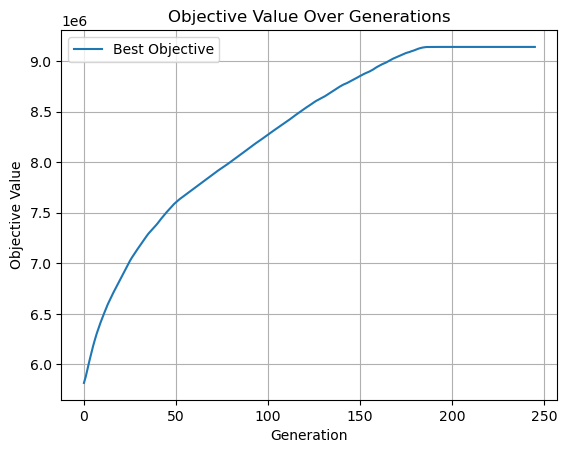

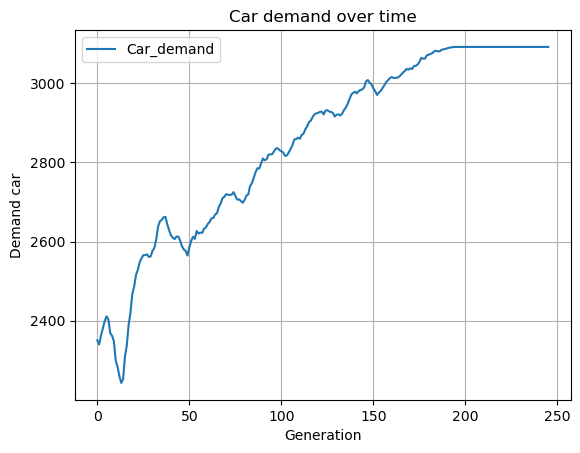

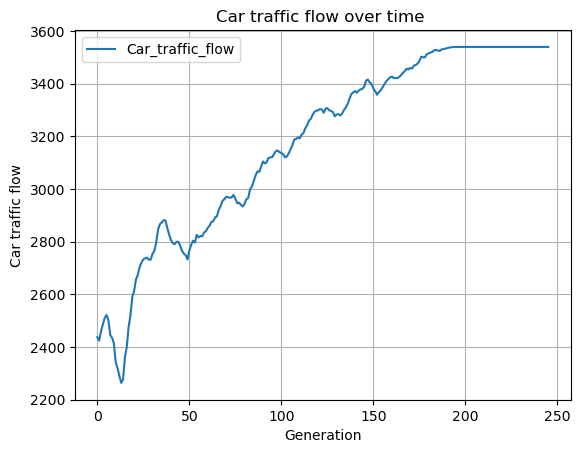

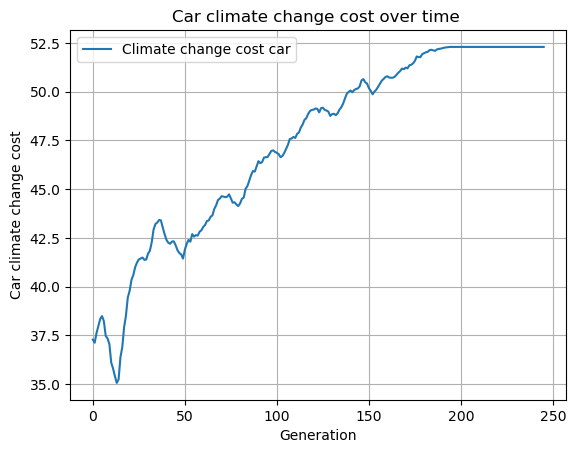

In [44]:
pop_size = 30
initial_solution = generate_population(pop_size, BS_fleet_bound, PT_fleet_bound, G_ver01, n_lines)
(
        initial_best_solution, best_individual, 
        initial_xa_c, initial_xa_bs, initial_xa_pt, 
        final_xa_c, final_xa_bs, final_xa_pt, 
        initial_qw_c, initial_qw_bs, initial_qw_pt,  
        initial_qw_cb, final_qw_c,final_qw_bs, 
        final_qw_pt, final_qw_cb, initial_fpw_c,
        final_fpw_c, initial_op, initial_cs, 
        initial_cc, initial_hb ,final_op, final_cs, 
        final_cc, final_hb
    ) = genetic_algorithm_ver02(initial_solution, G_ver01, population_size=30, iterations=250)

In [44]:
print("Final Best Solution:", best_individual)
print("Best initial solution:", initial_best_solution)

Final Best Solution: [5.6, 1.44, 3.15, 0.7, 1.78, 54, 70, 96, 5, 99, 70, 32.0, 47.0, 59.0, 64.0, 33.0, 23.0, 41.0, 100.0, 47.0, 18.0, 45.0, 7.0]
Best initial solution: [  2.43   0.56   2.69   0.37   1.58  47.    65.    35.    44.    81.
  78.    24.    47.    59.    64.    33.    23.    41.   100.    47.
  18.    45.     7.  ]


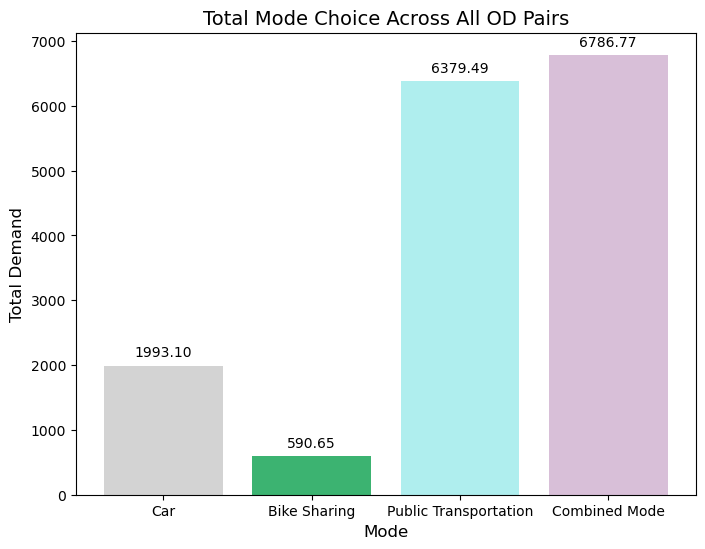

Final solution modal share None


In [45]:
print("Final solution modal share", visualize_mode_choice_sumation(final_qw_c,final_qw_bs, final_qw_pt, final_qw_cb, all_paths))

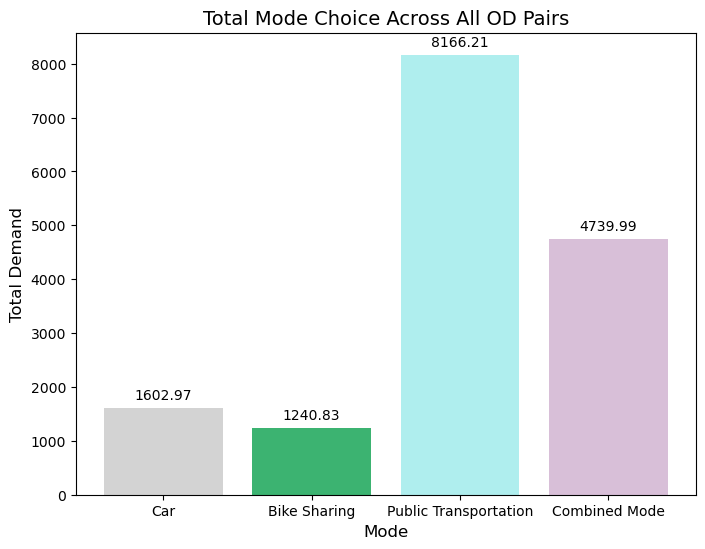

Initial solution modal share None


In [46]:
print("Initial solution modal share", visualize_mode_choice_sumation(initial_qw_c, initial_qw_bs, initial_qw_pt, initial_qw_cb, all_paths))

In [48]:
print("Objective function final solution:", final_op, final_cs, final_cc, final_hb)
print("Objective function initial solution:", initial_op, initial_cs, initial_cc, initial_hb)

Objective function final solution: 681591.8503404779 3374954.626693898 31.28838680161732 882.0367760853247
Objective function initial solution: 93727.5983538928 3374954.626693898 23.856294633467982 863.1351668843514


# ==================================================================================================================================================================

# scaling the component of the objective function 

In [69]:
def compute_fitness_ver02(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_Cost_bike, 
                    Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                    V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, 
                    Bike_Number_Constraint_ver01, public_number_constraint, 
                    qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c):
    
    # Calculate each component of the objective function
    OP = operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, individual[0], individual[1], individual[2], 
                                individual[3], individual[4], Run_Cost_bike, lines_dict, number_bike, number_public, 
                                qw_c, qw_bs, qw_pt, qw_cb)

    CS = consumer_surplus(Demand, all_paths, mu, {
        'car': lambda: utility_car_ver01(all_paths, THE_LENGTH, FREE_FLOW_TRAVEL_TIME, ca, xa_c, travel_time_value_car, individual[2], G_ver01),
        'bike_sharing': lambda: utility_bike_ver01(all_paths, THE_LENGTH, vb, travel_time_value_bike, individual[0], G_ver01),
        'public_transport': lambda: utility_public_ver01(all_paths, THE_LENGTH, vp, travel_time_value_public, individual[0], G_ver01, lines_dict, HEADWAY),
        'combined': lambda: utility_combine_ver01(all_paths, all_paths_with_modes_cb, THE_LENGTH, lines_dict, vp, vb, 
                           HEADWAY, travel_time_value_combined, individual[3], individual[4])})

    CC = Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, xa_bs, xa_pt, xa_c)
    HealthB = Health_benefit(G_ver01, THE_LENGTH, xa_bs, HB, vb)

    # Combine them into the total objective function (OF)
    OF = OP + CS + (-(CC) + HealthB)

    # Vectorized Constraint Checks
    no_bike = Bike_Number_Constraint_ver01(qw_bs, qw_cb, all_paths, THE_LENGTH, vb)
    no_pt = public_number_constraint(HEADWAY, lines_dict)

    # Apply the constraints and penalize if violated
    no_bike_array = np.array([no_bike[i] for i in G_ver01.nodes()])
    number_bike_array = np.array([number_bike[i] for i in G_ver01.nodes()])
    OF -= 1000 * np.sum(no_bike_array > number_bike_array)

    no_pt_array = np.array([no_pt[line] for line in lines_dict])
    number_public_array = np.array([number_public[line] for line in lines_dict])
    OF -= 1000 * np.sum(no_pt_array > number_public_array)

    return -OF, OP, CS, CC, HealthB

# =========================================================================================
# Main fitness computation with scaling

# Initialize lists to store component values for scaling
OP_values = []
CS_values = []
CC_values = []
HealthB_values = []

# Iterate over the population to compute the fitness for each individual
for individual in pop:
    fitness, OP, CS, CC, HealthB = compute_fitness_ver02(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike, 
                                                         Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car, 
                                                         V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01, 
                                                         public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)
    # Store the values of each component
    OP_values.append(OP)
    CS_values.append(CS)
    CC_values.append(CC)
    HealthB_values.append(HealthB)

# Convert the lists to numpy arrays
OP_values = np.array(OP_values)
CS_values = np.array(CS_values)
CC_values = np.array(CC_values)
HealthB_values = np.array(HealthB_values)

# =========================================================================================
# Helper function to handle division by zero in scaling
def safe_min_max_scale(values, value_min, value_max):
    if value_max == value_min:  # If all values are the same
        return np.ones_like(values)  # Assign default value (1) or 0 based on your needs
    return (values - value_min) / (value_max - value_min)

# Compute min/max for each component
OP_min, OP_max = np.min(OP_values), np.max(OP_values)
CS_min, CS_max = np.min(CS_values), np.max(CS_values)
CC_min, CC_max = np.min(CC_values), np.max(CC_values)
HealthB_min, HealthB_max = np.min(HealthB_values), np.max(HealthB_values)

# Scale each component, handling division by zero
OP_scaled = safe_min_max_scale(OP_values, OP_min, OP_max)
CS_scaled = safe_min_max_scale(CS_values, CS_min, CS_max)
CC_scaled = safe_min_max_scale(CC_values, CC_min, CC_max)
HealthB_scaled = safe_min_max_scale(HealthB_values, HealthB_min, HealthB_max)

# =========================================================================================
# Optional: Apply weights to each component (if needed)
w_OP = 0.15  # Weight for operator surplus
w_CS = 0.15  # Weight for consumer surplus
w_CC = 0.4  # Weight for climate change cost
w_HealthB = 0.3  # Weight for health benefit

# Compute the weighted objective function for each individual
scaled_OF_values = w_OP * OP_scaled + w_CS * CS_scaled - w_CC * CC_scaled + w_HealthB * HealthB_scaled

# =========================================================================================
# Print the final scaled and weighted objective function values
print(scaled_OF_values)

[-0.0471378  -0.03139433 -0.01155052  0.01869     0.04086375  0.1549256
  0.04829153  0.10598158  0.01476191  0.06889849  0.05592994 -0.00165663
  0.09183611 -0.03142663  0.10518179  0.2        -0.1         0.14702245
  0.08895186  0.16048954]


In [70]:
# Scale the objective function to range between 0 and 1 (min-max normalization)
def scale_objective_function(OF_values):
    min_OF = min(OF_values)
    max_OF = max(OF_values)
    if max_OF - min_OF == 0:  # Prevent division by zero
        return [0 for _ in OF_values]  # If all OF_values are the same, scale them to 0
    scaled_OF = [(OF - min_OF) / (max_OF - min_OF) for OF in OF_values]
    return scaled_OF

# Modify the main genetic algorithm function to include scaled objective function
def genetic_algorithm_ver02(initial_solution, G_ver01, population_size=10, iterations=15):

    population = initial_solution  # Initial population
    HEADWAY = {'Line1': 5, 'Line2': 5, 'Line3': 5}
    best_fitness_over_time = []  # List to store best fitness values for each generation
    total_cars_over_time = []
    demand_car_over_time = []
    total_emission = []
    total_op = []
    total_cs = []
    total_hb = []

    fitness_shift = 0  # Initialize fitness shift to keep fitness positive if necessary
    OF_values = []
    traffic_flows = []
    
    # Initial evaluation of the population
    for i in range(len(population)):
        individual = population[i]
        price_bs = individual[1]
        price_pt = individual[2]
        price_c = individual[0]
        price_bs_cb = individual[3]
        price_pt_cb = individual[4]
        number_bike_list = individual[5:20]
        number_bike = {i: j for i, j in zip(G_ver01.nodes(), number_bike_list)}
        number_public_list = individual[20:23]
        number_public = {j: i for i, j in zip(number_public_list, lines_dict)}

        fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca,
            travel_time_value_car, travel_time_value_bike, travel_time_value_public,
            travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car,
            travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01,
            utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing,
            update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road,
            initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)

        fitness, OP, CS, CC, HealthB = compute_fitness_ver02(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike,
            Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car,
            V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01,
            public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)

        OF_values.append(fitness)
        traffic_flows.append((xa_c, xa_bs, xa_pt, qw_c, qw_bs, qw_pt, qw_cb, fpw_c))

    # Scale the objective function values
    scaled_OF_values = scale_objective_function(OF_values)

    # Identify the initial best solution
    initial_best_index = np.argmin(OF_values)
    initial_best_solution = population[initial_best_index]
    initial_best_fitness = -OF_values[initial_best_index]
    initial_xa_c, initial_xa_bs, initial_xa_pt, initial_qw_c, initial_qw_bs, initial_qw_pt, initial_qw_cb, initial_fpw_c = traffic_flows[initial_best_index]

    initial_op = operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                                       price_bs_cb, price_pt_cb, Run_cost_bike, lines_dict, number_bike_ver01, number_public_ver01, initial_qw_c,
                                       initial_qw_bs, initial_qw_pt, initial_qw_cb)

    initial_cs = consumer_surplus(Demand, all_paths, mu, utilities_functions)

    initial_cc = Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public,
                              F_public, I_public, social_co2, initial_xa_bs, initial_xa_pt, initial_xa_c)

    initial_hb = Health_benefit(G_ver01, THE_LENGTH, initial_xa_bs, HB, vb)
    print(f'Initial Best Fitness (Maximized OF) = {initial_best_fitness}')

    # Evolution Process
    for generation in range(iterations):
        OF_values = []
        traffic_flows = []

        for i in range(len(population)):
            individual = population[i]
            price_bs = individual[1]
            price_pt = individual[2]
            price_c = individual[0]
            price_bs_cb = individual[3]
            price_pt_cb = individual[4]
            number_bike_list = individual[5:20]
            number_bike = {i: j for i, j in zip(G_ver01.nodes(), number_bike_list)}
            number_public_list = individual[20:23]
            number_public = {j: i for i, j in zip(number_public_list, lines_dict)}

            fpw_c, qw_c, qw_bs, qw_pt, qw_cb, xa_c, xa_bs, xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca,
                travel_time_value_car, travel_time_value_bike, travel_time_value_public,
                travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car,
                travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01,
                utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing,
                update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road,
                initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)

            fitness, OP, CS, CC, HealthB = compute_fitness_ver02(individual, G_ver01, lines_dict, all_paths, xa_bs, Run_cost_public, Run_cost_bike,
                Demand, all_paths_with_modes_cb, THE_LENGTH, HEADWAY, vb, mu, V_car, F_car, I_Car,
                V_bike, F_bike, I_bike, V_public, F_public, I_public, social_co2, HB, Bike_Number_Constraint_ver01,
                public_number_constraint, qw_c, qw_bs, qw_pt, qw_cb, xa_pt, xa_c)

            OF_values.append(fitness)

        # Scale the objective function values for this generation
        scaled_OF_values = scale_objective_function(OF_values)

        # Handle negative fitness values
        if min(OF_values) < 0:
            fitness_shift = abs(min(OF_values)) + 10
        else:
            fitness_shift = 0

        shifted_fitness_values = [fitness + fitness_shift for fitness in OF_values]

        # Identify the best solution for this generation
        best_index = np.argmin(OF_values)
        best_individual = population[best_index]
        best_fitness = -OF_values[best_index]
        best_fitness_over_time.append(best_fitness)

        # Update values for the best individual
        price_c = best_individual[0]
        price_bs = best_individual[1]
        price_pt = best_individual[2]
        price_bs_cb = best_individual[3]
        price_pt_cb = best_individual[4]

        final_fpw_c, final_qw_c, final_qw_bs, final_qw_pt, final_qw_cb, final_xa_c, final_xa_bs, final_xa_pt, HEADWAY = traffic_simulation_VER01(individual, G_ver01, lines_dict, all_paths, Demand, THE_LENGTH, vb, vp, ca,
            travel_time_value_car, travel_time_value_bike, travel_time_value_public,
            travel_time_value_combined, FREE_FLOW_TRAVEL_TIME, travel_time_car,
            travel_time_bs, travel_time_public, utility_car_ver01, utility_bike_ver01,
            utility_public_ver01, utility_combine_ver01, logit_mode_choice, update_all_or_nothing,
            update_flows_msa, update_demand_on_fp_car, initial_no_passenger_road,
            initial_traffic_flow_link, initial_deman_mode, initial_passenger_link, update_headway)

        final_op = operator_surplus_ver01(all_paths, all_paths_with_modes_cb, Run_cost_public, price_bs, price_pt, price_c,
                                           price_bs_cb, price_pt_cb, Run_cost_bike, lines_dict, number_bike_ver01, number_public_ver01, final_qw_c,
                                           final_qw_bs, final_qw_pt, final_qw_cb)

        final_cs = consumer_surplus(Demand, all_paths, mu, utilities_functions)

        final_cc = Climate_change(G_ver01, THE_LENGTH, V_car, F_car, I_Car, V_bike, F_bike, I_bike, V_public,
                                  F_public, I_public, social_co2, final_xa_bs, final_xa_pt, final_xa_c)

        final_hb = Health_benefit(G_ver01, THE_LENGTH, final_xa_bs, HB, vb)
        print(f'Generation {generation + 1}: Best Fitness (Maximized OF) = {best_fitness}')
        # ========================================================================================================================================
        XC = 0
        XBS=0
        XPT=0
        for i, j in G_ver01.edges():
            XBS += final_xa_bs.get((i, j), 0) * THE_LENGTH[i][j]
            XPT += final_xa_pt.get((i, j), 0) * THE_LENGTH[i][j]
            XC += final_xa_c.get((i, j), 0)

        # print(f'Generation {generation + 1}: cilmate change cost car = {final_cc}')
        # print(f'Generation {generation + 1}: Number of cars  = {XC}')
        # print(f'Generation {generation + 1}: Demand Car = {sum(final_qw_c.values())}')

        demand_car_over_time.append(sum(final_qw_c.values()))  # Track car demand
        total_cars_over_time.append(XC)  # Track total car usage
        total_emission.append(final_cc)
        total_op.append(final_op)
        total_cs.append(final_cs)
        total_hb.append(final_hb)
        # ========================================================================================================================================
        # Elitism: Keep the best individuals
        elite_size = max(1, int(0.1 * population_size))
        sorted_indices = np.argsort(OF_values)
        elite_individuals = [population[i] for i in sorted_indices[:elite_size]]

        new_population = elite_individuals

        # Dynamic mutation rate
        initial_mutation_rate = 0.1
        decay_rate = 0.1
        mutation_rate = initial_mutation_rate / (1 + decay_rate * generation)

        # Generate new population via crossover and mutation
        while len(new_population) < population_size:
            parent1, parent2 = select_parents(population, scaled_OF_values, tournament_size=5)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, BS_fleet_bound, PT_fleet_bound, max_mutation_factor=mutation_rate)
            child2 = mutate(child2, BS_fleet_bound, PT_fleet_bound, max_mutation_factor=mutation_rate)

            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)

        population = new_population

    # Plot the fitness evolution
    smoothed_fitness = smooth(best_fitness_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Best Objective')
    plt.xlabel('Generation')
    plt.ylabel('Objective Value')
    plt.title('Objective Value Over Generations')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(demand_car_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Car_demand')
    plt.xlabel('Generation')
    plt.ylabel('Demand car')
    plt.title('Car demand over time')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_cars_over_time, window_size=5)
    plt.plot(smoothed_fitness, label='Car_traffic_flow'
    '')
    plt.xlabel('Generation')
    plt.ylabel('Car traffic flow')
    plt.title('Car traffic flow over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_emission, window_size=5)
    plt.plot(smoothed_fitness, label='Climate change cost ')
    plt.xlabel('Generation')
    plt.ylabel('Car climate change cost')
    plt.title('Car climate change cost over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_op, window_size=5)
    plt.plot(smoothed_fitness, label='Operators surplus')
    plt.xlabel('Generation')
    plt.ylabel('Operators surplus')
    plt.title('Operators surplus over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_cs, window_size=5)
    plt.plot(smoothed_fitness, label='Consumer surplus')
    plt.xlabel('Generation')
    plt.ylabel('Consumer surplus')
    plt.title('CConsumer surplus over time ')
    plt.legend()
    plt.grid()
    plt.show()

    smoothed_fitness = smooth(total_hb, window_size=5)
    plt.plot(smoothed_fitness, label='Health benefit')
    plt.xlabel('Generation')
    plt.ylabel('Health benefitt')
    plt.title('Health benefit over time ')
    plt.legend()
    plt.grid()
    plt.show()
    # Return both the initial and final best solutions along with traffic flows
    return (
        initial_best_solution, best_individual, 
        initial_xa_c, initial_xa_bs, initial_xa_pt, 
        final_xa_c, final_xa_bs, final_xa_pt, 
        initial_qw_c, initial_qw_bs, initial_qw_pt, 
        initial_qw_cb, final_qw_c,final_qw_bs, 
        final_qw_pt, final_qw_cb, initial_fpw_c,
        final_fpw_c, initial_op, initial_cs, 
        initial_cc, initial_hb ,final_op, final_cs, 
        final_cc, final_hb
    )

# Results with weight of one 

Initial Best Fitness (Maximized OF) = 5567066.700635417
Generation 1: Best Fitness (Maximized OF) = 5567066.700635417
Generation 2: Best Fitness (Maximized OF) = 5682065.895798307
Generation 3: Best Fitness (Maximized OF) = 5804684.765854917
Generation 4: Best Fitness (Maximized OF) = 5866121.980455624
Generation 5: Best Fitness (Maximized OF) = 5945269.696360718
Generation 6: Best Fitness (Maximized OF) = 5987577.142983606
Generation 7: Best Fitness (Maximized OF) = 6065152.641869816
Generation 8: Best Fitness (Maximized OF) = 6124872.064228549
Generation 9: Best Fitness (Maximized OF) = 6190747.99541571
Generation 10: Best Fitness (Maximized OF) = 6216046.721830401
Generation 11: Best Fitness (Maximized OF) = 6278788.872139145
Generation 12: Best Fitness (Maximized OF) = 6324877.851082582
Generation 13: Best Fitness (Maximized OF) = 6370763.528061664
Generation 14: Best Fitness (Maximized OF) = 6424582.399020573
Generation 15: Best Fitness (Maximized OF) = 6464816.896201803
Generatio

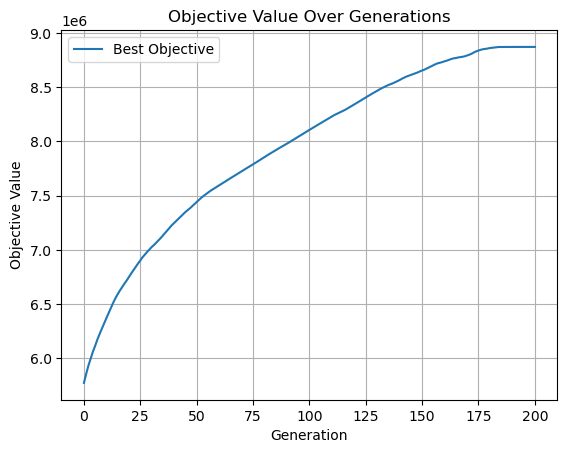

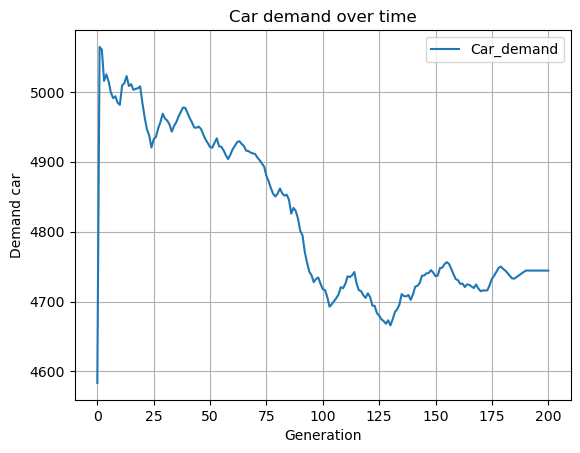

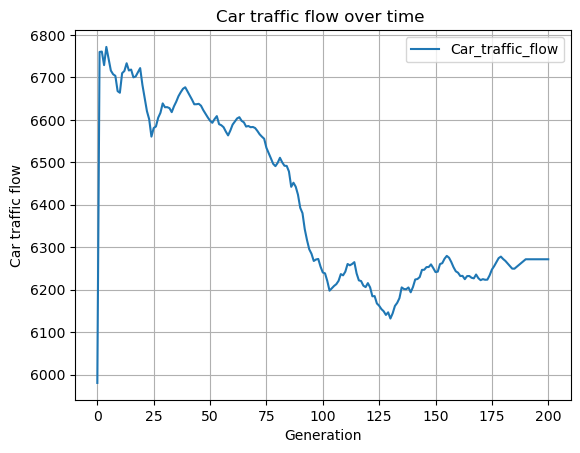

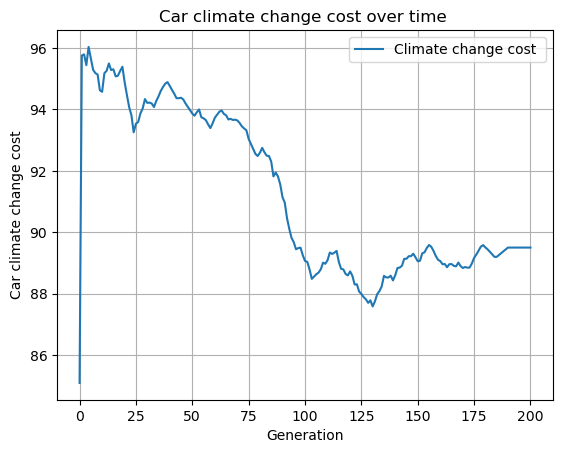

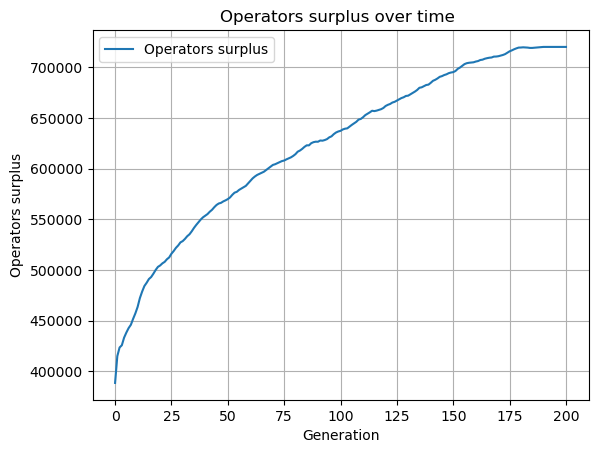

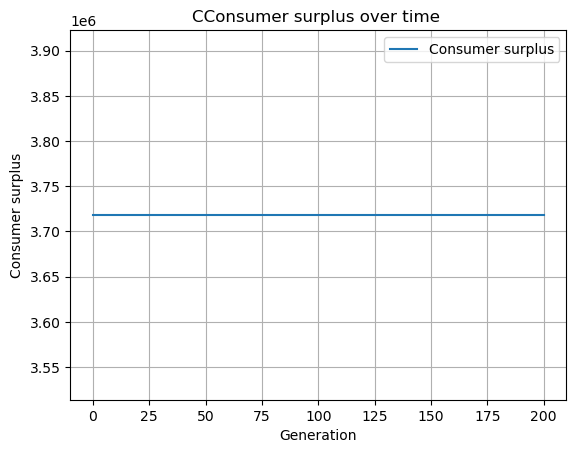

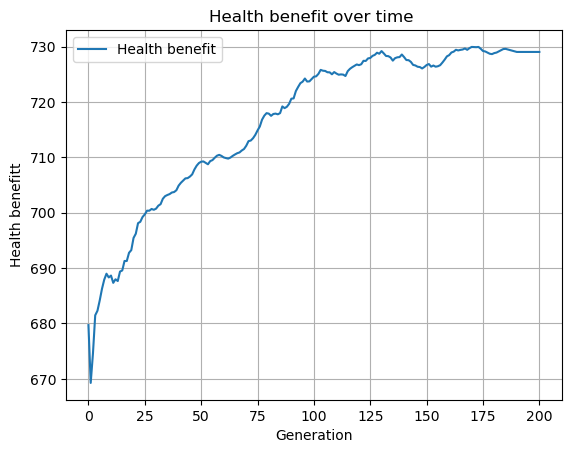

In [64]:
pop_size = 20
initial_solution = generate_population(pop_size, BS_fleet_bound, PT_fleet_bound, G_ver01, n_lines)
(
        initial_best_solution, best_individual, 
        initial_xa_c, initial_xa_bs, initial_xa_pt, 
        final_xa_c, final_xa_bs, final_xa_pt, 
        initial_qw_c, initial_qw_bs, initial_qw_pt,  
        initial_qw_cb, final_qw_c,final_qw_bs, 
        final_qw_pt, final_qw_cb, initial_fpw_c,
        final_fpw_c, initial_op, initial_cs, 
        initial_cc, initial_hb ,final_op, final_cs, 
        final_cc, final_hb
    ) = genetic_algorithm_ver02(initial_solution, G_ver01, population_size=20, iterations=205)

In [65]:
print("Final Best Solution:", best_individual)
print("Best initial solution:", initial_best_solution)

Final Best Solution: [5.56, 1.5, 1.44, 0.68, 1.89, 49.0, 41.0, 5, 54, 31, 52.0, 44, 21.0, 22.0, 66.0, 93.0, 5.0, 39.0, 37.0, 50.0, 17.0, 23.0, 31.0]
Best initial solution: [  2.35   0.9    0.68   0.52   1.84 100.    18.    78.    16.    95.
  68.    76.    21.    22.    66.    93.     5.    39.    37.    50.
  17.    23.    31.  ]


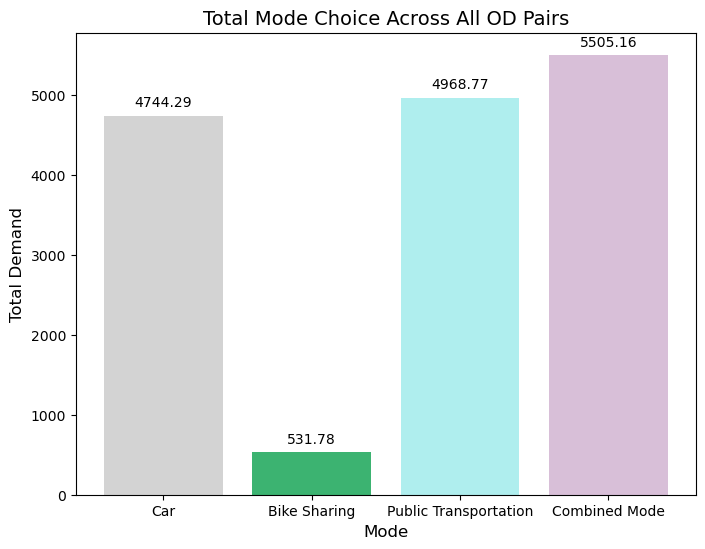

Final solution modal share None


In [66]:
print("Final solution modal share", visualize_mode_choice_sumation(final_qw_c,final_qw_bs, final_qw_pt, final_qw_cb, all_paths))

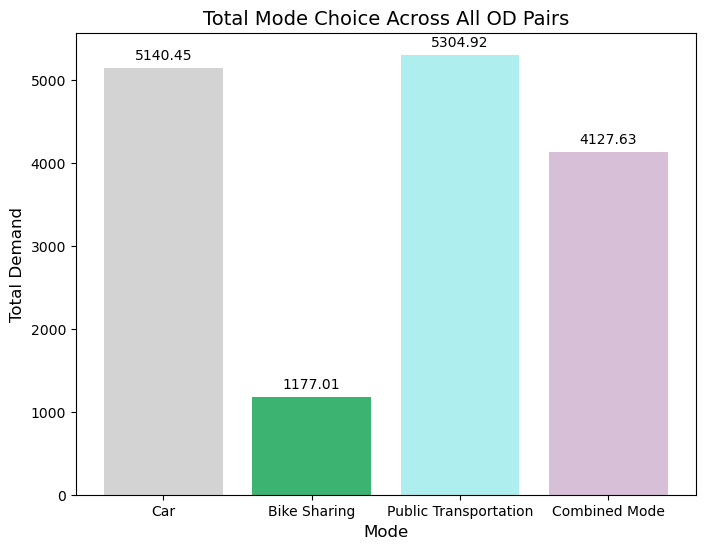

Initial solution modal share None


In [67]:
print("Initial solution modal share", visualize_mode_choice_sumation(initial_qw_c, initial_qw_bs, initial_qw_pt, initial_qw_cb, all_paths))

In [68]:
print("Objective function final solution:", final_op, final_cs, final_cc, final_hb)
print("Objective function initial solution:", initial_op, initial_cs, initial_cc, initial_hb)

Objective function final solution: 720114.9607393456 3718316.776748272 89.49815631070655 729.0645876418962
Objective function initial solution: 471784.32313457935 3718316.776748272 96.87263084971357 668.7881292168363


# ===========================================================================================================================

# Results with weight of : OP = 0.15, CS = 0.15, CC= 0.4, HB =0.4

Initial Best Fitness (Maximized OF) = 5469167.1183365155
Generation 1: Best Fitness (Maximized OF) = 5469167.1183365155
Generation 2: Best Fitness (Maximized OF) = 5254022.024321015
Generation 3: Best Fitness (Maximized OF) = 5356565.1905353805
Generation 4: Best Fitness (Maximized OF) = 5430188.363113452
Generation 5: Best Fitness (Maximized OF) = 5503878.260839401
Generation 6: Best Fitness (Maximized OF) = 5550490.865014782
Generation 7: Best Fitness (Maximized OF) = 5628512.772998963
Generation 8: Best Fitness (Maximized OF) = 5721690.365709735
Generation 9: Best Fitness (Maximized OF) = 5769785.687780315
Generation 10: Best Fitness (Maximized OF) = 5816863.716347126
Generation 11: Best Fitness (Maximized OF) = 5867728.611404673
Generation 12: Best Fitness (Maximized OF) = 5938491.3528165305
Generation 13: Best Fitness (Maximized OF) = 5973993.626690208
Generation 14: Best Fitness (Maximized OF) = 6023620.002476398
Generation 15: Best Fitness (Maximized OF) = 6070889.520336925
Gene

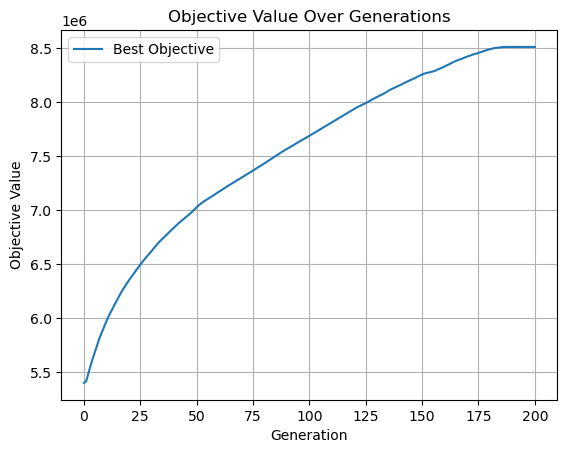

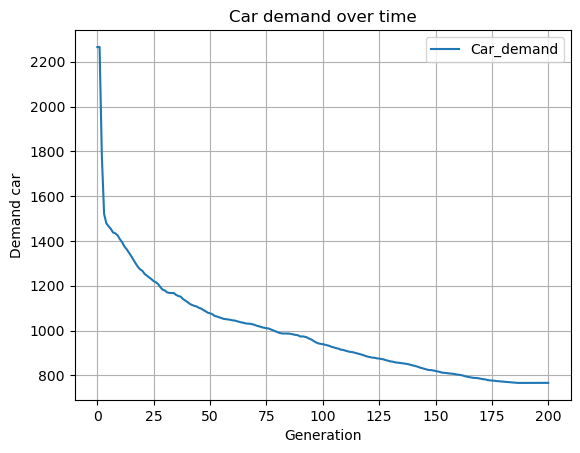

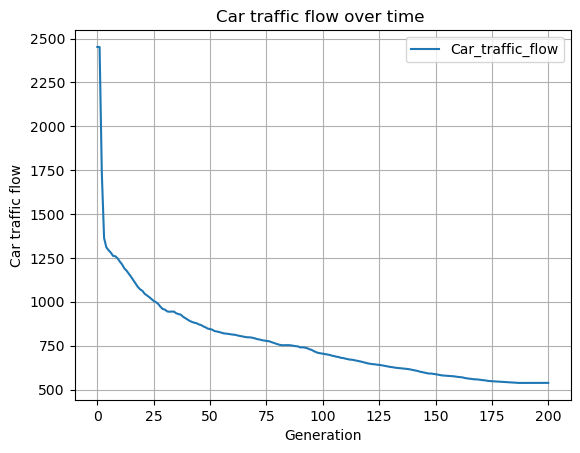

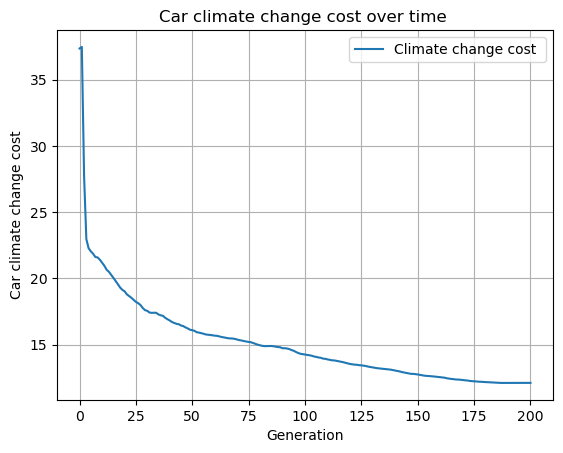

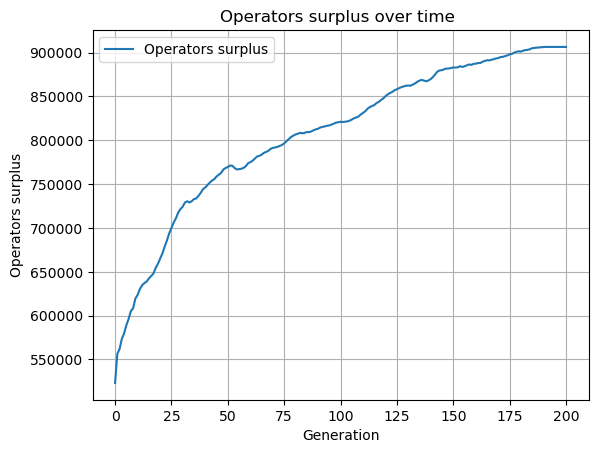

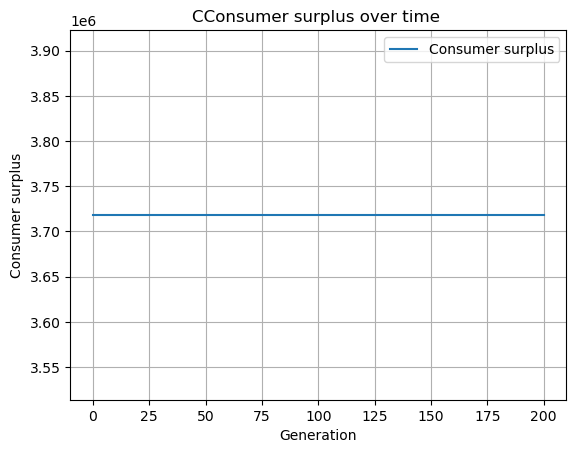

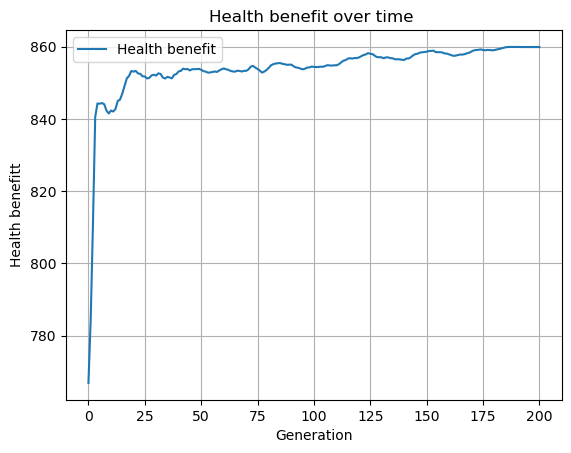

In [71]:
pop_size = 20
initial_solution = generate_population(pop_size, BS_fleet_bound, PT_fleet_bound, G_ver01, n_lines)
(
        initial_best_solution, best_individual, 
        initial_xa_c, initial_xa_bs, initial_xa_pt, 
        final_xa_c, final_xa_bs, final_xa_pt, 
        initial_qw_c, initial_qw_bs, initial_qw_pt,  
        initial_qw_cb, final_qw_c,final_qw_bs, 
        final_qw_pt, final_qw_cb, initial_fpw_c,
        final_fpw_c, initial_op, initial_cs, 
        initial_cc, initial_hb ,final_op, final_cs, 
        final_cc, final_hb
    ) = genetic_algorithm_ver02(initial_solution, G_ver01, population_size=20, iterations=205)

In [72]:
print("Final Best Solution:", best_individual)
print("Best initial solution:", initial_best_solution)

Final Best Solution: [2.77, 1.77, 5.53, 1.3, 1.85, 76, 96, 75.0, 18.0, 20, 87.0, 41, 75.0, 46.0, 17.0, 90.0, 77.0, 23.0, 31.0, 69.0, 49.0, 14.0, 40.0]
Best initial solution: [  2.53   1.     1.26   0.55   0.73 100.    37.    81.    15.    40.
   7.    43.    97.    65.    46.    65.     9.    27.    15.    93.
  50.    21.    33.  ]


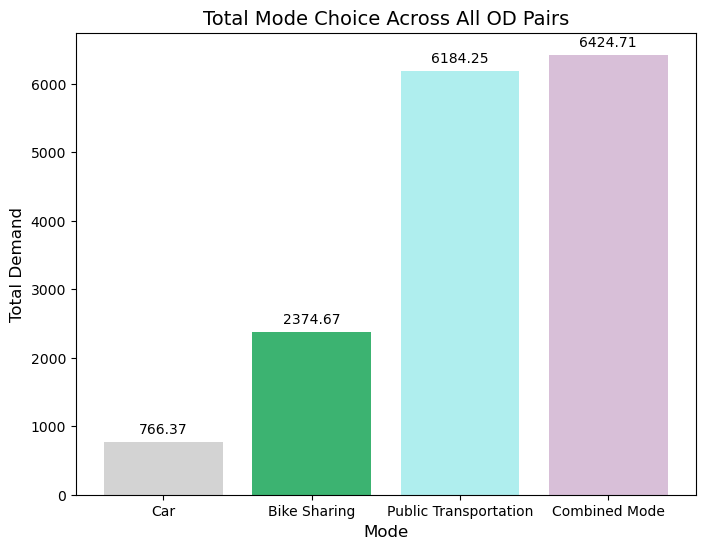

Final solution modal share None


In [73]:
print("Final solution modal share", visualize_mode_choice_sumation(final_qw_c,final_qw_bs, final_qw_pt, final_qw_cb, all_paths))

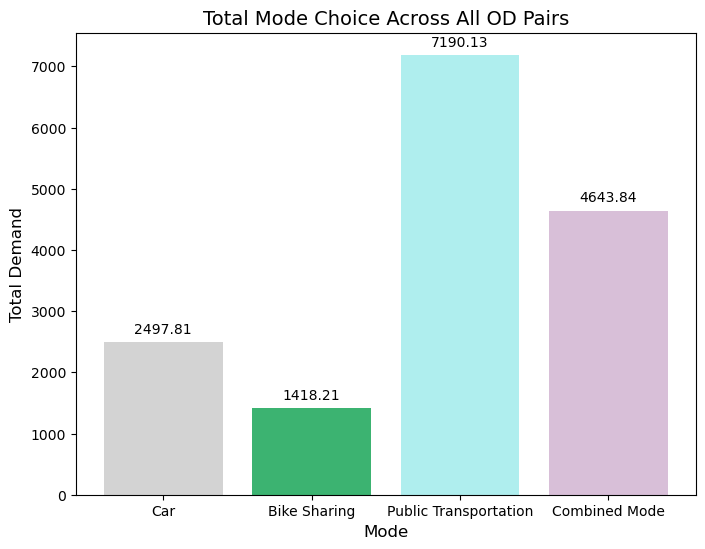

Initial solution modal share None


In [74]:
print("Initial solution modal share", visualize_mode_choice_sumation(initial_qw_c, initial_qw_bs, initial_qw_pt, initial_qw_cb, all_paths))

In [75]:
print("Objective function final solution:", final_op, final_cs, final_cc, final_hb)
print("Objective function initial solution:", initial_op, initial_cs, initial_cc, initial_hb)

Objective function final solution: 906538.290248172 3718316.776748272 12.102528748962452 859.8638019080108
Objective function initial solution: 422503.12021893146 3718316.776748272 39.50355803543533 766.7447626653599
